# 你的第一个神经网络

在此项目中，你将构建你的第一个神经网络，并用该网络预测每日自行车租客人数。我们提供了一些代码，但是需要你来实现神经网络（大部分内容）。提交此项目后，欢迎进一步探索该数据和模型。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 加载和准备数据

构建神经网络的关键一步是正确地准备数据。不同尺度级别的变量使网络难以高效地掌握正确的权重。我们在下方已经提供了加载和准备数据的代码。你很快将进一步学习这些代码！

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## 数据简介

此数据集包含的是从 2011 年 1 月 1 日到 2012 年 12 月 31 日期间每天每小时的骑车人数。骑车用户分成临时用户和注册用户，cnt 列是骑车用户数汇总列。你可以在上方看到前几行数据。

下图展示的是数据集中前 10 天左右的骑车人数（某些天不一定是 24 个条目，所以不是精确的 10 天）。你可以在这里看到每小时租金。这些数据很复杂！周末的骑行人数少些，工作日上下班期间是骑行高峰期。我们还可以从上方的数据中看到温度、湿度和风速信息，所有这些信息都会影响骑行人数。你需要用你的模型展示所有这些数据。

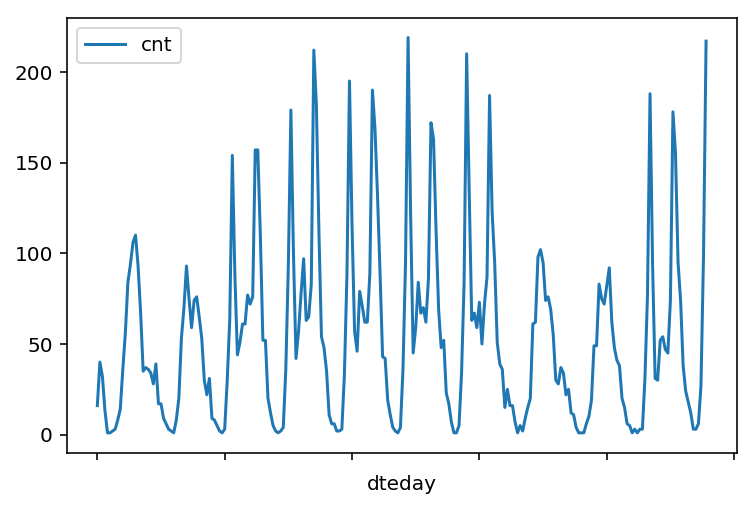

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### 虚拟变量（哑变量）

下面是一些分类变量，例如季节、天气、月份。要在我们的模型中包含这些数据，我们需要创建二进制虚拟变量。用 Pandas 库中的 `get_dummies()` 就可以轻松实现。

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### 调整目标变量

为了更轻松地训练网络，我们将对每个连续变量标准化，即转换和调整变量，使它们的均值为 0，标准差为 1。

我们会保存换算因子，以便当我们使用网络进行预测时可以还原数据。

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### 将数据拆分为训练、测试和验证数据集

我们将大约最后 21 天的数据保存为测试数据集，这些数据集会在训练完网络后使用。我们将使用该数据集进行预测，并与实际的骑行人数进行对比。

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

我们将数据拆分为两个数据集，一个用作训练，一个在网络训练完后用来验证网络。因为数据是有时间序列特性的，所以我们用历史数据进行训练，然后尝试预测未来数据（验证数据集）。

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## 开始构建网络

下面你将构建自己的网络。我们已经构建好结构和反向传递部分。你将实现网络的前向传递部分。还需要设置超参数：学习速率、隐藏单元的数量，以及训练传递数量。

<img src="assets/neural_network.png" width=300px>

该网络有两个层级，一个隐藏层和一个输出层。隐藏层级将使用 S 型函数作为激活函数。输出层只有一个节点，用于递归，节点的输出和节点的输入相同。即激活函数是 $f(x)=x$。这种函数获得输入信号，并生成输出信号，但是会考虑阈值，称为激活函数。我们完成网络的每个层级，并计算每个神经元的输出。一个层级的所有输出变成下一层级神经元的输入。这一流程叫做前向传播（forward propagation）。

我们在神经网络中使用权重将信号从输入层传播到输出层。我们还使用权重将错误从输出层传播回网络，以便更新权重。这叫做反向传播（backpropagation）。

> **提示**：你需要为反向传播实现计算输出激活函数 ($f(x) = x$) 的导数。如果你不熟悉微积分，其实该函数就等同于等式 $y = x$。该等式的斜率是多少？也就是导数 $f(x)$。


你需要完成以下任务：

1. 实现 S 型激活函数。将 `__init__` 中的 `self.activation_function`  设为你的 S 型函数。
2. 在 `train` 方法中实现前向传递。
3. 在 `train` 方法中实现反向传播算法，包括计算输出错误。
4. 在 `run` 方法中实现前向传递。

  

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        def sigmoid(x):
           return 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation here
        self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs =  np.dot(X, self.weights_input_to_hidden)# signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            output_error_term = error * 1
            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
           
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h +=  hidden_error_term * X[:, None]
            # Weight step (hidden to output)
            delta_weights_h_o +=  output_error_term * hidden_outputs[:, None]

        # TODO: Update the weights - Replace these values with your calculations.
    
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
            
        print(final_outputs)
        return final_outputs

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## 单元测试

运行这些单元测试，检查你的网络实现是否正确。这样可以帮助你确保网络已正确实现，然后再开始训练网络。这些测试必须成功才能通过此项目。

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

[[0.09998924]]



----------------------------------------------------------------------
Ran 5 tests in 0.003s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## 训练网络

现在你将设置网络的超参数。策略是设置的超参数使训练集上的错误很小但是数据不会过拟合。如果网络训练时间太长，或者有太多的隐藏节点，可能就会过于针对特定训练集，无法泛化到验证数据集。即当训练集的损失降低时，验证集的损失将开始增大。

你还将采用随机梯度下降 (SGD) 方法训练网络。对于每次训练，都获取随机样本数据，而不是整个数据集。与普通梯度下降相比，训练次数要更多，但是每次时间更短。这样的话，网络训练效率更高。稍后你将详细了解 SGD。


### 选择迭代次数

也就是训练网络时从训练数据中抽样的批次数量。迭代次数越多，模型就与数据越拟合。但是，如果迭代次数太多，模型就无法很好地泛化到其他数据，这叫做过拟合。你需要选择一个使训练损失很低并且验证损失保持中等水平的数字。当你开始过拟合时，你会发现训练损失继续下降，但是验证损失开始上升。

### 选择学习速率

速率可以调整权重更新幅度。如果速率太大，权重就会太大，导致网络无法与数据相拟合。建议从 0.1 开始。如果网络在与数据拟合时遇到问题，尝试降低学习速率。注意，学习速率越低，权重更新的步长就越小，神经网络收敛的时间就越长。


### 选择隐藏节点数量

隐藏节点越多，模型的预测结果就越准确。尝试不同的隐藏节点的数量，看看对性能有何影响。你可以查看损失字典，寻找网络性能指标。如果隐藏单元的数量太少，那么模型就没有足够的空间进行学习，如果太多，则学习方向就有太多的选择。选择隐藏单元数量的技巧在于找到合适的平衡点。

In [21]:
import sys

### TODO:Set the hyperparameters here, you need to change the defalut to get a better solution ###
iterations = 3000
learning_rate = 0.5
hidden_nodes = 13
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

[[-0.01320249]
 [-0.09867558]
 [-0.03309096]
 ...
 [ 0.01274556]
 [ 0.0870936 ]
 [ 0.14480992]]
[[0.15071382]
 [0.0962183 ]
 [0.17890545]
 ...
 [0.04841845]
 [0.09540155]
 [0.0522871 ]]
Progress: 0.0% ... Training loss: 0.942 ... Validation loss: 1.319[[-0.1941207 ]
 [-0.28375263]
 [-0.22121149]
 ...
 [-0.14168695]
 [-0.06853618]
 [-0.01808611]]
[[ 0.00271851]
 [-0.03071966]
 [ 0.06248405]
 ...
 [-0.08660703]
 [-0.05241384]
 [-0.09494217]]
Progress: 0.0% ... Training loss: 0.915 ... Validation loss: 1.389[[-0.12165289]
 [-0.21285295]
 [-0.14786066]
 ...
 [-0.05722239]
 [ 0.0172903 ]
 [ 0.08054532]]
[[ 0.10442496]
 [ 0.07691036]
 [ 0.17406363]
 ...
 [ 0.01413791]
 [ 0.03714801]
 [-0.01256771]]
Progress: 0.1% ... Training loss: 0.899 ... Validation loss: 1.312[[-0.04464974]
 [-0.1381803 ]
 [-0.06785026]
 ...
 [ 0.02561144]
 [ 0.10187365]
 [ 0.18550841]]
[[0.22292315]
 [0.21416476]
 [0.31961655]
 ...
 [0.13841714]
 [0.14773799]
 [0.07739952]]
Progress: 0.1% ... Training loss: 0.907 ... Va

d:\program\anoconda3-5.1.0\envs\ai\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


[[-0.48489386]
 [-0.6013723 ]
 [-0.52887712]
 ...
 [-0.26866836]
 [-0.18620326]
 [-0.07305725]]
[[ 0.03499556]
 [ 0.11489852]
 [ 0.27857535]
 ...
 [-0.04767653]
 [-0.11830249]
 [-0.22235783]]
Progress: 0.3% ... Training loss: 0.756 ... Validation loss: 1.247[[-0.73494418]
 [-0.85256197]
 [-0.78546532]
 ...
 [-0.50439753]
 [-0.42379166]
 [-0.31983398]]
[[-0.19864885]
 [-0.09974403]
 [ 0.07591402]
 ...
 [-0.26717762]
 [-0.35015795]
 [-0.45264099]]
Progress: 0.4% ... Training loss: 0.776 ... Validation loss: 1.454[[-0.46188477]
 [-0.5827443 ]
 [-0.508811  ]
 ...
 [-0.22060364]
 [-0.13369502]
 [-0.00350465]]
[[ 0.11999953]
 [ 0.21961646]
 [ 0.39570615]
 ...
 [ 0.04184579]
 [-0.05350042]
 [-0.17189993]]
Progress: 0.4% ... Training loss: 0.749 ... Validation loss: 1.169[[-0.82238266]
 [-0.94430873]
 [-0.87588698]
 ...
 [-0.55769576]
 [-0.47445383]
 [-0.36405672]]
[[-0.23275946]
 [-0.12659055]
 [ 0.05649903]
 ...
 [-0.31203832]
 [-0.40989215]
 [-0.5168929 ]]
Progress: 0.4% ... Training loss: 

Progress: 1.4% ... Training loss: 0.601 ... Validation loss: 1.015[[-1.1927041 ]
 [-1.33743249]
 [-1.25076911]
 ...
 [-0.52252884]
 [-0.39170942]
 [-0.22810252]]
[[ 0.02565398]
 [ 0.20561234]
 [ 0.42640599]
 ...
 [-0.11952184]
 [-0.37777739]
 [-0.48351166]]
Progress: 1.4% ... Training loss: 0.610 ... Validation loss: 1.137[[-0.95371788]
 [-1.10042126]
 [-1.01004126]
 ...
 [-0.30551682]
 [-0.1675855 ]
 [ 0.02021933]]
[[ 0.27493471]
 [ 0.44659374]
 [ 0.66305187]
 ...
 [ 0.12536685]
 [-0.13709989]
 [-0.26198904]]
Progress: 1.4% ... Training loss: 0.609 ... Validation loss: 0.965[[-1.08086917]
 [-1.2282144 ]
 [-1.14584271]
 ...
 [-0.4132282 ]
 [-0.27751523]
 [-0.1064183 ]]
[[ 0.1557846 ]
 [ 0.32365988]
 [ 0.54240877]
 ...
 [ 0.00718833]
 [-0.25571315]
 [-0.36320577]]
Progress: 1.5% ... Training loss: 0.592 ... Validation loss: 1.029[[-1.00577339]
 [-1.15470148]
 [-1.06965123]
 ...
 [-0.30377352]
 [-0.16320534]
 [ 0.01421827]]
[[ 0.27756297]
 [ 0.44030808]
 [ 0.66073374]
 ...
 [ 0.11272199]

Progress: 2.4% ... Training loss: 0.521 ... Validation loss: 0.795[[-1.41900025]
 [-1.57949632]
 [-1.51108549]
 ...
 [-0.47870742]
 [-0.27766202]
 [-0.08571535]]
[[ 0.25445636]
 [ 0.29660007]
 [ 0.48138235]
 ...
 [-0.01819476]
 [-0.36390101]
 [-0.39264097]]
Progress: 2.5% ... Training loss: 0.544 ... Validation loss: 0.959[[-0.93778153]
 [-1.10283928]
 [-1.02155262]
 ...
 [-0.02113133]
 [ 0.19086955]
 [ 0.44858174]]
[[0.79687972]
 [0.83105536]
 [1.01491678]
 ...
 [0.50361342]
 [0.14498728]
 [0.06303606]]
Progress: 2.5% ... Training loss: 0.588 ... Validation loss: 0.794[[-1.44392713]
 [-1.60263621]
 [-1.53684203]
 ...
 [-0.49269055]
 [-0.28644059]
 [-0.09501164]]
[[ 0.2601349 ]
 [ 0.2952426 ]
 [ 0.47830126]
 ...
 [-0.0244138 ]
 [-0.36881203]
 [-0.39975337]]
Progress: 2.5% ... Training loss: 0.546 ... Validation loss: 0.956[[-0.96098889]
 [-1.12226406]
 [-1.04650812]
 ...
 [-0.03250705]
 [ 0.18230293]
 [ 0.41742404]]
[[0.75591968]
 [0.74624528]
 [0.91083793]
 ...
 [0.44295448]
 [0.10767

Progress: 3.5% ... Training loss: 0.420 ... Validation loss: 0.692[[-1.219923  ]
 [-1.39186724]
 [-1.31762324]
 ...
 [-0.17974752]
 [ 0.09157382]
 [ 0.48745513]]
[[0.96008161]
 [0.80818303]
 [0.91079096]
 ...
 [0.56777659]
 [0.15102696]
 [0.02358776]]
Progress: 3.5% ... Training loss: 0.430 ... Validation loss: 0.669[[-1.56157497]
 [-1.72485954]
 [-1.66273492]
 ...
 [-0.55705099]
 [-0.28880472]
 [ 0.08794523]]
[[ 0.561358  ]
 [ 0.39952505]
 [ 0.49959267]
 ...
 [ 0.16051502]
 [-0.24439196]
 [-0.35863974]]
Progress: 3.6% ... Training loss: 0.496 ... Validation loss: 0.816[[-1.16751721]
 [-1.335502  ]
 [-1.26456524]
 ...
 [-0.2097375 ]
 [ 0.06479148]
 [ 0.4955373 ]]
[[9.66984806e-01]
 [7.94807679e-01]
 [8.85612401e-01]
 ...
 [5.62421626e-01]
 [1.60489898e-01]
 [1.72358707e-04]]
Progress: 3.6% ... Training loss: 0.422 ... Validation loss: 0.671[[-1.35873588]
 [-1.52508902]
 [-1.4614732 ]
 ...
 [-0.36541376]
 [-0.08490386]
 [ 0.33791045]]
[[ 8.22029026e-01]
 [ 6.60210205e-01]
 [ 7.55608208e

Progress: 4.6% ... Training loss: 0.426 ... Validation loss: 0.671[[-1.45693647]
 [-1.62088834]
 [-1.58138432]
 ...
 [-0.42431553]
 [-0.10810047]
 [ 0.35569264]]
[[ 0.85678458]
 [ 0.36756546]
 [ 0.30638298]
 ...
 [ 0.34569558]
 [-0.06680535]
 [-0.11824066]]
Progress: 4.6% ... Training loss: 0.487 ... Validation loss: 0.703[[-0.84310201]
 [-1.01230215]
 [-0.95605974]
 ...
 [ 0.14724369]
 [ 0.47311377]
 [ 1.06975705]]
[[1.60480292]
 [1.18812386]
 [1.14537609]
 ...
 [1.13649213]
 [0.67945481]
 [0.49533052]]
Progress: 4.6% ... Training loss: 0.552 ... Validation loss: 0.780[[-1.60880055]
 [-1.7606011 ]
 [-1.72371138]
 ...
 [-0.61842155]
 [-0.31228364]
 [ 0.20271148]]
[[ 0.76735688]
 [ 0.35006894]
 [ 0.31974904]
 ...
 [ 0.30705997]
 [-0.14745375]
 [-0.27042387]]
Progress: 4.7% ... Training loss: 0.487 ... Validation loss: 0.710[[-0.88805241]
 [-1.04382112]
 [-0.99176016]
 ...
 [ 0.13337509]
 [ 0.45486479]
 [ 1.08039361]]
[[1.65042634]
 [1.25256596]
 [1.21735624]
 ...
 [1.19651928]
 [0.72116

Progress: 5.6% ... Training loss: 0.358 ... Validation loss: 0.579[[-1.36319605]
 [-1.5124016 ]
 [-1.49547597]
 ...
 [-0.4281231 ]
 [-0.0848311 ]
 [ 0.56067986]]
[[1.23729309]
 [0.72683283]
 [0.62527759]
 ...
 [0.74469693]
 [0.23999332]
 [0.04341598]]
Progress: 5.7% ... Training loss: 0.329 ... Validation loss: 0.526[[-1.1697736 ]
 [-1.31623048]
 [-1.30460934]
 ...
 [-0.20224582]
 [ 0.15237102]
 [ 0.77897732]]
[[1.44964198]
 [0.87485855]
 [0.74691664]
 ...
 [0.91042455]
 [0.42574961]
 [0.2634838 ]]
Progress: 5.7% ... Training loss: 0.346 ... Validation loss: 0.534[[-1.31866373]
 [-1.46214709]
 [-1.45676327]
 ...
 [-0.36382873]
 [-0.01483347]
 [ 0.60815993]]
[[1.29473409]
 [0.73326408]
 [0.60620497]
 ...
 [0.77689929]
 [0.29820926]
 [0.13444537]]
Progress: 5.7% ... Training loss: 0.329 ... Validation loss: 0.527[[-1.28751358]
 [-1.43113851]
 [-1.42883581]
 ...
 [-0.31533891]
 [ 0.03563362]
 [ 0.65530572]]
[[1.33998999]
 [0.75471668]
 [0.61653914]
 ...
 [0.81742507]
 [0.34758238]
 [0.185

 [ 0.58544898]]
[[1.3036935 ]
 [0.72818098]
 [0.56276021]
 ...
 [0.85744387]
 [0.30885557]
 [0.0730784 ]]
Progress: 6.7% ... Training loss: 0.315 ... Validation loss: 0.488[[-1.26773852]
 [-1.38718176]
 [-1.42277157]
 ...
 [-0.38976266]
 [-0.02505489]
 [ 0.71356768]]
[[1.43489315]
 [0.86042912]
 [0.68891693]
 ...
 [1.01444525]
 [0.4677287 ]
 [0.21693781]]
Progress: 6.8% ... Training loss: 0.319 ... Validation loss: 0.491[[-1.48342505]
 [-1.60167178]
 [-1.64183112]
 ...
 [-0.54128397]
 [-0.18071415]
 [ 0.54936634]]
[[1.29689843]
 [0.71746823]
 [0.55404115]
 ...
 [0.88998176]
 [0.33251871]
 [0.08504952]]
Progress: 6.8% ... Training loss: 0.318 ... Validation loss: 0.492[[-1.32966896]
 [-1.45154826]
 [-1.48880104]
 ...
 [-0.41394518]
 [-0.06274581]
 [ 0.684522  ]]
[[1.41383741]
 [0.82315575]
 [0.6496583 ]
 ...
 [0.99233689]
 [0.44985736]
 [0.19928818]]
Progress: 6.8% ... Training loss: 0.315 ... Validation loss: 0.486[[-1.32950841]
 [-1.44917136]
 [-1.48761583]
 ...
 [-0.37053563]
 [-0.01

Progress: 7.8% ... Training loss: 0.348 ... Validation loss: 0.534[[-1.29678086]
 [-1.38709001]
 [-1.44881293]
 ...
 [-0.45207945]
 [-0.09537823]
 [ 0.62965708]]
[[1.43856896]
 [0.8324666 ]
 [0.6019177 ]
 ...
 [1.04839492]
 [0.45480183]
 [0.20894895]]
Progress: 7.8% ... Training loss: 0.311 ... Validation loss: 0.486[[-1.29453749]
 [-1.38802976]
 [-1.44413601]
 ...
 [-0.44331109]
 [-0.08221819]
 [ 0.66903674]]
[[1.45649585]
 [0.87184141]
 [0.64114849]
 ...
 [1.08153615]
 [0.48359008]
 [0.21696215]]
Progress: 7.9% ... Training loss: 0.313 ... Validation loss: 0.486[[-1.30160012]
 [-1.39317377]
 [-1.45714509]
 ...
 [-0.44961412]
 [-0.08630312]
 [ 0.63094718]]
[[1.38707348]
 [0.72338898]
 [0.46466371]
 ...
 [0.95732076]
 [0.39211379]
 [0.17933673]]
Progress: 7.9% ... Training loss: 0.307 ... Validation loss: 0.489[[-1.40063679]
 [-1.49142096]
 [-1.55435306]
 ...
 [-0.51341548]
 [-0.14974053]
 [ 0.58836551]]
[[1.37776343]
 [0.79067424]
 [0.55051603]
 ...
 [1.00654329]
 [0.40016926]
 [0.156

Progress: 8.9% ... Training loss: 0.300 ... Validation loss: 0.465[[-1.32315613]
 [-1.4331129 ]
 [-1.48666431]
 ...
 [-0.4564494 ]
 [-0.09512528]
 [ 0.64201924]]
[[1.47882569]
 [0.8556433 ]
 [0.62214925]
 ...
 [1.06003882]
 [0.46653222]
 [0.19429373]]
Progress: 8.9% ... Training loss: 0.307 ... Validation loss: 0.462[[-1.32680916]
 [-1.43364598]
 [-1.48990123]
 ...
 [-0.46033359]
 [-0.1017306 ]
 [ 0.65074094]]
[[1.45676676]
 [0.78948483]
 [0.54279159]
 ...
 [0.99822088]
 [0.416039  ]
 [0.15392703]]
Progress: 9.0% ... Training loss: 0.303 ... Validation loss: 0.465[[-1.48446965]
 [-1.5905969 ]
 [-1.6470983 ]
 ...
 [-0.62493659]
 [-0.27003643]
 [ 0.45316772]]
[[1.27353606]
 [0.64499927]
 [0.39288068]
 ...
 [0.84594678]
 [0.2745382 ]
 [0.00815367]]
Progress: 9.0% ... Training loss: 0.322 ... Validation loss: 0.485[[-1.24841132]
 [-1.35304567]
 [-1.4058498 ]
 ...
 [-0.38039235]
 [-0.02229038]
 [ 0.6982486 ]]
[[1.50405883]
 [0.8398593 ]
 [0.57076442]
 ...
 [1.07260902]
 [0.52792201]
 [0.269

[[1.36182189]
 [0.7079994 ]
 [0.44148054]
 ...
 [0.93833432]
 [0.39619126]
 [0.00499461]]
Progress: 10.0% ... Training loss: 0.305 ... Validation loss: 0.473[[-1.15258239]
 [-1.22783871]
 [-1.28275992]
 ...
 [-0.48254197]
 [-0.11248202]
 [ 0.70537141]]
[[1.56908113]
 [0.88980866]
 [0.61840837]
 ...
 [1.12828542]
 [0.5991538 ]
 [0.21062599]]
Progress: 10.0% ... Training loss: 0.309 ... Validation loss: 0.480[[-1.23082224]
 [-1.3078902 ]
 [-1.35823073]
 ...
 [-0.52815183]
 [-0.15608348]
 [ 0.67461623]]
[[1.56508634]
 [0.92870731]
 [0.6649603 ]
 ...
 [1.13680902]
 [0.5916704 ]
 [0.17341178]]
Progress: 10.1% ... Training loss: 0.311 ... Validation loss: 0.470[[-1.41863196]
 [-1.49164466]
 [-1.55129433]
 ...
 [-0.71244179]
 [-0.34192761]
 [ 0.41536448]]
[[ 1.28514332]
 [ 0.58754998]
 [ 0.30407825]
 ...
 [ 0.82998065]
 [ 0.31733972]
 [-0.03460976]]
Progress: 10.1% ... Training loss: 0.327 ... Validation loss: 0.501[[-1.19036472]
 [-1.26194046]
 [-1.31912547]
 ...
 [-0.41261597]
 [-0.03357505

Progress: 11.1% ... Training loss: 0.320 ... Validation loss: 0.494[[-1.34867604]
 [-1.41726068]
 [-1.48187861]
 ...
 [-0.59143426]
 [-0.24430427]
 [ 0.49689048]]
[[1.32464526]
 [0.63403889]
 [0.40062793]
 ...
 [0.94722864]
 [0.45394484]
 [0.10312242]]
Progress: 11.1% ... Training loss: 0.308 ... Validation loss: 0.485[[-1.19732232]
 [-1.27110021]
 [-1.32887148]
 ...
 [-0.41596399]
 [-0.06496377]
 [ 0.67792313]]
[[1.50510238]
 [0.81361388]
 [0.57423955]
 ...
 [1.12351465]
 [0.62605306]
 [0.2838793 ]]
Progress: 11.1% ... Training loss: 0.300 ... Validation loss: 0.483[[-1.44711452]
 [-1.52079339]
 [-1.58280783]
 ...
 [-0.58604624]
 [-0.23718541]
 [ 0.47843151]]
[[1.30294105]
 [0.63862597]
 [0.39783747]
 ...
 [0.94179927]
 [0.4388487 ]
 [0.11809401]]
Progress: 11.2% ... Training loss: 0.312 ... Validation loss: 0.485[[-1.34233041]
 [-1.41296505]
 [-1.47134574]
 ...
 [-0.51619488]
 [-0.16906862]
 [ 0.60375042]]
[[1.42539261]
 [0.82945194]
 [0.61505185]
 ...
 [1.07378943]
 [0.54027205]
 [0

Progress: 12.2% ... Training loss: 0.292 ... Validation loss: 0.455[[-1.32795911]
 [-1.41096861]
 [-1.44287529]
 ...
 [-0.47627806]
 [-0.12520955]
 [ 0.66998275]]
[[1.51498996]
 [0.87147387]
 [0.62464071]
 ...
 [1.07831518]
 [0.50175581]
 [0.13736603]]
Progress: 12.2% ... Training loss: 0.294 ... Validation loss: 0.453[[-1.40146301]
 [-1.48523961]
 [-1.51661514]
 ...
 [-0.53326434]
 [-0.18511961]
 [ 0.59780021]]
[[1.44773277]
 [0.81496146]
 [0.57077591]
 ...
 [1.02227912]
 [0.44509237]
 [0.09061059]]
Progress: 12.2% ... Training loss: 0.292 ... Validation loss: 0.452[[-1.34610045]
 [-1.43116235]
 [-1.46020706]
 ...
 [-0.4854382 ]
 [-0.1396005 ]
 [ 0.63875164]]
[[1.46477973]
 [0.80060652]
 [0.53288502]
 ...
 [1.02881042]
 [0.48668554]
 [0.13479442]]
Progress: 12.3% ... Training loss: 0.293 ... Validation loss: 0.460[[-1.26947204]
 [-1.35352444]
 [-1.37962013]
 ...
 [-0.42596637]
 [-0.07622167]
 [ 0.70959022]]
[[1.51522388]
 [0.83378114]
 [0.56516951]
 ...
 [1.07788304]
 [0.53951009]
 [0

[[1.6428111 ]
 [0.97361017]
 [0.76042053]
 ...
 [1.10956696]
 [0.53180126]
 [0.14914514]]
Progress: 13.3% ... Training loss: 0.293 ... Validation loss: 0.443[[-1.34738718]
 [-1.43955977]
 [-1.44906718]
 ...
 [-0.39534846]
 [-0.05303338]
 [ 0.83931392]]
[[1.70702686]
 [1.05797067]
 [0.84732887]
 ...
 [1.17759218]
 [0.60090091]
 [0.18589789]]
Progress: 13.3% ... Training loss: 0.298 ... Validation loss: 0.457[[-1.33845521]
 [-1.43205665]
 [-1.44424882]
 ...
 [-0.38696534]
 [-0.04583553]
 [ 0.80924709]]
[[1.66272283]
 [0.94759749]
 [0.72303499]
 ...
 [1.07141981]
 [0.51982517]
 [0.15125175]]
Progress: 13.3% ... Training loss: 0.290 ... Validation loss: 0.447[[-1.27228057]
 [-1.36612983]
 [-1.37683395]
 ...
 [-0.38293173]
 [-0.04232752]
 [ 0.82681778]]
[[1.68163241]
 [0.972728  ]
 [0.75072576]
 ...
 [1.1145635 ]
 [0.56189336]
 [0.17955115]]
Progress: 13.4% ... Training loss: 0.289 ... Validation loss: 0.457[[-1.27478137]
 [-1.36942282]
 [-1.37678276]
 ...
 [-0.38110152]
 [-0.03980468]
 [ 0

Progress: 14.3% ... Training loss: 0.331 ... Validation loss: 0.485[[-1.17162372]
 [-1.25138173]
 [-1.25559208]
 ...
 [-0.41961815]
 [-0.06976097]
 [ 0.77273209]]
[[1.65869961]
 [0.93412678]
 [0.72376489]
 ...
 [1.08581697]
 [0.48088932]
 [0.14446669]]
Progress: 14.4% ... Training loss: 0.305 ... Validation loss: 0.466[[-1.44920864]
 [-1.52320858]
 [-1.53927913]
 ...
 [-0.73251713]
 [-0.39135426]
 [ 0.40749892]]
[[ 1.31079827]
 [ 0.58361788]
 [ 0.36777868]
 ...
 [ 0.75781231]
 [ 0.17601816]
 [-0.1424499 ]]
Progress: 14.4% ... Training loss: 0.324 ... Validation loss: 0.481[[-1.18149343]
 [-1.25961154]
 [-1.27051991]
 ...
 [-0.45867461]
 [-0.11342298]
 [ 0.70691372]]
[[1.59308243]
 [0.85695625]
 [0.63289708]
 ...
 [1.03486582]
 [0.4480549 ]
 [0.1234345 ]]
Progress: 14.4% ... Training loss: 0.294 ... Validation loss: 0.457[[-1.36967791]
 [-1.44642615]
 [-1.4634357 ]
 ...
 [-0.6708611 ]
 [-0.3339926 ]
 [ 0.47273945]]
[[ 1.36444761]
 [ 0.63328128]
 [ 0.40641518]
 ...
 [ 0.83271535]
 [ 0.24

Progress: 15.4% ... Training loss: 0.313 ... Validation loss: 0.501[[-1.45373208]
 [-1.52731593]
 [-1.54745319]
 ...
 [-0.70722538]
 [-0.36973024]
 [ 0.44566771]]
[[ 1.26431877]
 [ 0.56854063]
 [ 0.34484561]
 ...
 [ 0.75578709]
 [ 0.17759288]
 [-0.12845343]]
Progress: 15.4% ... Training loss: 0.344 ... Validation loss: 0.495[[-1.14146409]
 [-1.22376129]
 [-1.2353983 ]
 ...
 [-0.38175406]
 [-0.03694803]
 [ 0.86268066]]
[[1.71042348]
 [1.08809566]
 [0.88697267]
 ...
 [1.21812527]
 [0.57921726]
 [0.19646314]]
Progress: 15.5% ... Training loss: 0.339 ... Validation loss: 0.503[[-1.49325057]
 [-1.57268955]
 [-1.59414567]
 ...
 [-0.75143704]
 [-0.41729062]
 [ 0.43507867]]
[[ 1.28212361]
 [ 0.62425883]
 [ 0.41330654]
 ...
 [ 0.7742552 ]
 [ 0.15637536]
 [-0.18077838]]
Progress: 15.5% ... Training loss: 0.322 ... Validation loss: 0.479[[-1.25557725]
 [-1.33819446]
 [-1.35508705]
 ...
 [-0.55226075]
 [-0.21378114]
 [ 0.69564167]]
[[1.56671737]
 [0.96508716]
 [0.76888993]
 ...
 [1.10630687]
 [0.4

Progress: 16.5% ... Training loss: 0.297 ... Validation loss: 0.472[[-1.09982384]
 [-1.18382176]
 [-1.21362812]
 ...
 [-0.46602457]
 [-0.10336599]
 [ 0.69526517]]
[[1.5326486 ]
 [0.89852405]
 [0.66895462]
 ...
 [1.12648693]
 [0.53239752]
 [0.20591787]]
Progress: 16.5% ... Training loss: 0.291 ... Validation loss: 0.459[[-1.2059706 ]
 [-1.29385634]
 [-1.32414898]
 ...
 [-0.58956164]
 [-0.23121887]
 [ 0.54836861]]
[[1.38727183]
 [0.74361488]
 [0.51422517]
 ...
 [0.96497553]
 [0.37499698]
 [0.07055224]]
Progress: 16.5% ... Training loss: 0.281 ... Validation loss: 0.452[[-1.18162049]
 [-1.27000618]
 [-1.29537889]
 ...
 [-0.57906117]
 [-0.21889755]
 [ 0.56570114]]
[[1.39479152]
 [0.74488883]
 [0.50887244]
 ...
 [0.98628294]
 [0.40261367]
 [0.09507201]]
Progress: 16.6% ... Training loss: 0.281 ... Validation loss: 0.455[[-1.10324261]
 [-1.19118253]
 [-1.21444558]
 ...
 [-0.51721398]
 [-0.15413578]
 [ 0.65431017]]
[[1.49474062]
 [0.84804087]
 [0.61500006]
 ...
 [1.08605916]
 [0.4951696 ]
 [0

Progress: 17.5% ... Training loss: 0.278 ... Validation loss: 0.451[[-1.20821466]
 [-1.28438831]
 [-1.32132898]
 ...
 [-0.67867206]
 [-0.33766353]
 [ 0.45400116]]
[[ 1.29155815]
 [ 0.63939586]
 [ 0.42850702]
 ...
 [ 0.91567125]
 [ 0.33856353]
 [-0.00219887]]
Progress: 17.6% ... Training loss: 0.285 ... Validation loss: 0.460[[-1.00220173]
 [-1.07630521]
 [-1.1115852 ]
 ...
 [-0.47418892]
 [-0.12778556]
 [ 0.67923149]]
[[1.49696019]
 [0.82736529]
 [0.60776796]
 ...
 [1.10123792]
 [0.52266455]
 [0.1823118 ]]
Progress: 17.6% ... Training loss: 0.288 ... Validation loss: 0.469[[-1.3531818 ]
 [-1.42642647]
 [-1.46805622]
 ...
 [-0.80336597]
 [-0.46890421]
 [ 0.28789279]]
[[ 1.08938981]
 [ 0.41510788]
 [ 0.18885935]
 ...
 [ 0.72037347]
 [ 0.16194488]
 [-0.13717673]]
Progress: 17.6% ... Training loss: 0.362 ... Validation loss: 0.539[[-0.7373479 ]
 [-0.81311187]
 [-0.842992  ]
 ...
 [-0.1571246 ]
 [ 0.19110131]
 [ 1.02868987]]
[[1.80646302]
 [1.12446427]
 [0.88786062]
 ...
 [1.39398005]
 [0.8

Progress: 18.6% ... Training loss: 0.362 ... Validation loss: 0.585[[-1.2859367 ]
 [-1.35271662]
 [-1.37967956]
 ...
 [-0.64371737]
 [-0.34345093]
 [ 0.51265499]]
[[ 1.39855981e+00]
 [ 7.07488192e-01]
 [ 4.72362305e-01]
 ...
 [ 9.45072740e-01]
 [ 3.44130299e-01]
 [-1.67495934e-04]]
Progress: 18.6% ... Training loss: 0.299 ... Validation loss: 0.452[[-1.09960932]
 [-1.17245563]
 [-1.19602365]
 ...
 [-0.4237233 ]
 [-0.11879256]
 [ 0.73441567]]
[[1.59525051]
 [0.88753105]
 [0.64869655]
 ...
 [1.11871019]
 [0.52201072]
 [0.19311733]]
Progress: 18.7% ... Training loss: 0.281 ... Validation loss: 0.456[[-1.16065513]
 [-1.23263593]
 [-1.25834152]
 ...
 [-0.52189263]
 [-0.21279939]
 [ 0.62178604]]
[[1.47339696]
 [0.76743889]
 [0.52434646]
 ...
 [1.00791174]
 [0.41932901]
 [0.10785535]]
Progress: 18.7% ... Training loss: 0.281 ... Validation loss: 0.450[[-1.07952332]
 [-1.15329877]
 [-1.1780336 ]
 ...
 [-0.41206964]
 [-0.09743097]
 [ 0.76782138]]
[[1.64598855]
 [0.94657438]
 [0.73030579]
 ...
 

Progress: 19.7% ... Training loss: 0.281 ... Validation loss: 0.452[[-1.06871179]
 [-1.1419872 ]
 [-1.17105852]
 ...
 [-0.39131688]
 [-0.08752387]
 [ 0.81753836]]
[[1.57970714]
 [0.88384422]
 [0.64178591]
 ...
 [1.16165525]
 [0.55762282]
 [0.25048029]]
Progress: 19.7% ... Training loss: 0.283 ... Validation loss: 0.472[[-1.26011577]
 [-1.32903616]
 [-1.36501758]
 ...
 [-0.62616729]
 [-0.327214  ]
 [ 0.55524893]]
[[1.33341852]
 [0.65502997]
 [0.42686633]
 ...
 [0.93568492]
 [0.33441849]
 [0.03011324]]
Progress: 19.7% ... Training loss: 0.288 ... Validation loss: 0.453[[-1.12581707]
 [-1.20091807]
 [-1.23206753]
 ...
 [-0.42435684]
 [-0.12137671]
 [ 0.7675676 ]]
[[1.5436917 ]
 [0.84135565]
 [0.61341236]
 ...
 [1.14572326]
 [0.52787912]
 [0.23215489]]
Progress: 19.8% ... Training loss: 0.285 ... Validation loss: 0.458[[-1.28326708]
 [-1.35647119]
 [-1.39106197]
 ...
 [-0.58154464]
 [-0.28297177]
 [ 0.58887066]]
[[1.38815436]
 [0.708309  ]
 [0.49267009]
 ...
 [1.01068888]
 [0.38323292]
 [0

[[1.63085797]
 [1.06574506]
 [0.85503097]
 ...
 [1.30627411]
 [0.61047068]
 [0.28504014]]
Progress: 20.8% ... Training loss: 0.325 ... Validation loss: 0.483[[-1.38192169]
 [-1.44550403]
 [-1.47729813]
 ...
 [-0.73916864]
 [-0.43414557]
 [ 0.37694047]]
[[ 1.18829408]
 [ 0.55816918]
 [ 0.31667413]
 ...
 [ 0.84748559]
 [ 0.21033289]
 [-0.06377532]]
Progress: 20.8% ... Training loss: 0.326 ... Validation loss: 0.482[[-0.92038583]
 [-0.99024862]
 [-1.01688633]
 ...
 [-0.26906428]
 [ 0.04525697]
 [ 0.91701682]]
[[1.70587242]
 [1.04708007]
 [0.79075623]
 ...
 [1.32757893]
 [0.6922239 ]
 [0.39259025]]
Progress: 20.8% ... Training loss: 0.327 ... Validation loss: 0.523[[-1.29783865]
 [-1.36027455]
 [-1.39728872]
 ...
 [-0.68507511]
 [-0.37678836]
 [ 0.42849042]]
[[ 1.20969285]
 [ 0.52139544]
 [ 0.25911443]
 ...
 [ 0.83096718]
 [ 0.2244149 ]
 [-0.02993245]]
Progress: 20.9% ... Training loss: 0.329 ... Validation loss: 0.489[[-0.90282834]
 [-0.96706088]
 [-0.9989081 ]
 ...
 [-0.24796774]
 [ 0.07

Progress: 21.8% ... Training loss: 0.277 ... Validation loss: 0.452[[-1.03265884]
 [-1.10427913]
 [-1.12894507]
 ...
 [-0.52463425]
 [-0.21078824]
 [ 0.61167119]]
[[1.48087576]
 [0.75497685]
 [0.49005709]
 ...
 [1.04911566]
 [0.42025793]
 [0.15639151]]
Progress: 21.9% ... Training loss: 0.272 ... Validation loss: 0.442[[-1.01357956]
 [-1.08404949]
 [-1.10941559]
 ...
 [-0.54208923]
 [-0.22947347]
 [ 0.60235323]]
[[1.47211188]
 [0.74499449]
 [0.47609911]
 ...
 [1.03608466]
 [0.41360933]
 [0.13962925]]
Progress: 21.9% ... Training loss: 0.272 ... Validation loss: 0.443[[-1.07270765]
 [-1.14161884]
 [-1.16839581]
 ...
 [-0.60995075]
 [-0.30382463]
 [ 0.54294897]]
[[1.42926229]
 [0.76085775]
 [0.5111945 ]
 ...
 [1.02779602]
 [0.38364766]
 [0.08498862]]
Progress: 21.9% ... Training loss: 0.271 ... Validation loss: 0.438[[-1.0748071 ]
 [-1.14257997]
 [-1.17426735]
 ...
 [-0.56276295]
 [-0.25588282]
 [ 0.55632585]]
[[1.42723473]
 [0.71229047]
 [0.43783541]
 ...
 [1.02170925]
 [0.40581561]
 [0

[[1.62084505]
 [1.03019203]
 [0.7950317 ]
 ...
 [1.2548796 ]
 [0.58689885]
 [0.25768399]]
Progress: 22.9% ... Training loss: 0.316 ... Validation loss: 0.471[[-1.2442943 ]
 [-1.29560774]
 [-1.35257618]
 ...
 [-0.72845932]
 [-0.4119212 ]
 [ 0.39467282]]
[[ 1.24513662]
 [ 0.57727659]
 [ 0.31636019]
 ...
 [ 0.87437821]
 [ 0.26167136]
 [-0.02069419]]
Progress: 23.0% ... Training loss: 0.311 ... Validation loss: 0.484[[-0.95368178]
 [-1.00497673]
 [-1.05514542]
 ...
 [-0.45615696]
 [-0.13401766]
 [ 0.74136493]]
[[1.59658558]
 [0.97545692]
 [0.72965661]
 ...
 [1.22872017]
 [0.59006429]
 [0.24947626]]
Progress: 23.0% ... Training loss: 0.294 ... Validation loss: 0.478[[-1.28139084]
 [-1.33054448]
 [-1.38674071]
 ...
 [-0.76494766]
 [-0.44914262]
 [ 0.3981884 ]]
[[ 1.24824017]
 [ 0.6413653 ]
 [ 0.39868545]
 ...
 [ 0.92011374]
 [ 0.28400545]
 [-0.03865745]]
Progress: 23.0% ... Training loss: 0.297 ... Validation loss: 0.471[[-0.97934859]
 [-1.03007525]
 [-1.08044413]
 ...
 [-0.41962704]
 [-0.09

Progress: 24.0% ... Training loss: 0.288 ... Validation loss: 0.461[[-1.05659235]
 [-1.11377419]
 [-1.14760827]
 ...
 [-0.48877813]
 [-0.1754679 ]
 [ 0.64918366]]
[[1.50698753]
 [0.8297787 ]
 [0.57364775]
 ...
 [1.08031528]
 [0.45820656]
 [0.17062694]]
Progress: 24.0% ... Training loss: 0.268 ... Validation loss: 0.449[[-1.22957521]
 [-1.28773179]
 [-1.32346132]
 ...
 [-0.65746321]
 [-0.34899917]
 [ 0.46046358]]
[[1.33009705]
 [0.6834625 ]
 [0.43249135]
 ...
 [0.91269446]
 [0.29406673]
 [0.00389296]]
Progress: 24.1% ... Training loss: 0.283 ... Validation loss: 0.462[[-1.02995034]
 [-1.08870425]
 [-1.12139456]
 ...
 [-0.43875056]
 [-0.12576902]
 [ 0.68769066]]
[[1.53829679]
 [0.85395548]
 [0.59217578]
 ...
 [1.08559454]
 [0.47706187]
 [0.20804087]]
Progress: 24.1% ... Training loss: 0.271 ... Validation loss: 0.453[[-1.03540263]
 [-1.09222593]
 [-1.12536378]
 ...
 [-0.48164321]
 [-0.17022763]
 [ 0.678951  ]]
[[1.55748397]
 [0.92975628]
 [0.69298794]
 ...
 [1.12360412]
 [0.4761186 ]
 [0

[[1.64697635]
 [0.96872157]
 [0.72685271]
 ...
 [1.2084486 ]
 [0.5765179 ]
 [0.27313811]]
Progress: 25.1% ... Training loss: 0.300 ... Validation loss: 0.485[[-0.99689248]
 [-1.05947764]
 [-1.10107231]
 ...
 [-0.46610267]
 [-0.15142849]
 [ 0.69598271]]
[[1.54710569]
 [0.82550918]
 [0.57254607]
 ...
 [1.09529124]
 [0.47634368]
 [0.20276141]]
Progress: 25.1% ... Training loss: 0.269 ... Validation loss: 0.452[[-1.10655447]
 [-1.17328443]
 [-1.21524427]
 ...
 [-0.52868348]
 [-0.21593121]
 [ 0.60142765]]
[[1.44820439]
 [0.70119849]
 [0.43891547]
 ...
 [0.97526297]
 [0.36621096]
 [0.12250879]]
Progress: 25.2% ... Training loss: 0.273 ... Validation loss: 0.446[[-1.01691918]
 [-1.08400534]
 [-1.12358998]
 ...
 [-0.45765333]
 [-0.14333728]
 [ 0.69563758]]
[[1.56937322]
 [0.83198733]
 [0.57556643]
 ...
 [1.08700977]
 [0.4686679 ]
 [0.19586597]]
Progress: 25.2% ... Training loss: 0.268 ... Validation loss: 0.452[[-1.09348977]
 [-1.16691247]
 [-1.20290049]
 ...
 [-0.51731468]
 [-0.20415873]
 [ 0

Progress: 26.2% ... Training loss: 0.268 ... Validation loss: 0.450[[-1.08975876]
 [-1.14775152]
 [-1.17492029]
 ...
 [-0.54840738]
 [-0.21993155]
 [ 0.62068379]]
[[1.48419371]
 [0.76953622]
 [0.52168159]
 ...
 [1.02384674]
 [0.42611265]
 [0.1551172 ]]
Progress: 26.2% ... Training loss: 0.264 ... Validation loss: 0.442[[-1.05937013]
 [-1.12050152]
 [-1.14638717]
 ...
 [-0.50282348]
 [-0.17045654]
 [ 0.69475339]]
[[1.56076772]
 [0.84394257]
 [0.59010244]
 ...
 [1.11686675]
 [0.5058816 ]
 [0.21652835]]
Progress: 26.2% ... Training loss: 0.269 ... Validation loss: 0.445[[-1.19277116]
 [-1.2563242 ]
 [-1.28355157]
 ...
 [-0.61867849]
 [-0.28799763]
 [ 0.58082855]]
[[1.43563623]
 [0.7218581 ]
 [0.46779106]
 ...
 [0.98488193]
 [0.36758168]
 [0.08364572]]
Progress: 26.3% ... Training loss: 0.271 ... Validation loss: 0.435[[-1.09330635]
 [-1.15439969]
 [-1.17952361]
 ...
 [-0.56565105]
 [-0.23394863]
 [ 0.63041961]]
[[1.47930353]
 [0.75229438]
 [0.50208388]
 ...
 [1.01384176]
 [0.40034408]
 [0

[[1.5491007 ]
 [0.77102692]
 [0.50707531]
 ...
 [1.00707672]
 [0.44631384]
 [0.19312027]]
Progress: 27.3% ... Training loss: 0.267 ... Validation loss: 0.445[[-1.15039549]
 [-1.20948852]
 [-1.24156709]
 ...
 [-0.57646105]
 [-0.25262172]
 [ 0.55691619]]
[[1.48241899]
 [0.75484989]
 [0.51428132]
 ...
 [0.95367592]
 [0.37279737]
 [0.10181684]]
Progress: 27.3% ... Training loss: 0.271 ... Validation loss: 0.437[[-0.94922662]
 [-1.00942737]
 [-1.03615639]
 ...
 [-0.32335948]
 [ 0.00393151]
 [ 0.85145505]]
[[1.78678747]
 [1.06287119]
 [0.82893663]
 ...
 [1.26760458]
 [0.6657205 ]
 [0.36601631]]
Progress: 27.3% ... Training loss: 0.306 ... Validation loss: 0.502[[-1.14280321]
 [-1.19828243]
 [-1.23048358]
 ...
 [-0.51382132]
 [-0.18553805]
 [ 0.61540997]]
[[1.53634562]
 [0.78142766]
 [0.53726888]
 ...
 [0.9953149 ]
 [0.41893087]
 [0.15770106]]
Progress: 27.4% ... Training loss: 0.269 ... Validation loss: 0.437[[-1.02183027]
 [-1.0782169 ]
 [-1.10833532]
 ...
 [-0.38548072]
 [-0.055561  ]
 [ 0

Progress: 28.3% ... Training loss: 0.267 ... Validation loss: 0.444[[-1.08505893]
 [-1.13991948]
 [-1.17490474]
 ...
 [-0.61458915]
 [-0.2885448 ]
 [ 0.5089966 ]]
[[1.3855241 ]
 [0.67780803]
 [0.47333815]
 ...
 [0.91001378]
 [0.35065707]
 [0.08017382]]
Progress: 28.4% ... Training loss: 0.263 ... Validation loss: 0.441[[-1.02943699]
 [-1.084316  ]
 [-1.11840582]
 ...
 [-0.59330762]
 [-0.26720676]
 [ 0.53412358]]
[[1.40738405]
 [0.70890947]
 [0.50195666]
 ...
 [0.95645511]
 [0.39945819]
 [0.12059108]]
Progress: 28.4% ... Training loss: 0.262 ... Validation loss: 0.445[[-1.1033159 ]
 [-1.16340595]
 [-1.19556399]
 ...
 [-0.68408366]
 [-0.36151822]
 [ 0.43393643]]
[[1.31921069]
 [0.63735488]
 [0.43663097]
 ...
 [0.88088815]
 [0.31559509]
 [0.02934216]]
Progress: 28.4% ... Training loss: 0.264 ... Validation loss: 0.439[[-1.00786599]
 [-1.06866211]
 [-1.09724901]
 ...
 [-0.60761138]
 [-0.28209192]
 [ 0.52754318]]
[[1.41956367]
 [0.72551854]
 [0.52423671]
 ...
 [0.96674211]
 [0.398403  ]
 [0

 [ 0.54597671]]
[[1.4721647 ]
 [0.74449641]
 [0.53579887]
 ...
 [1.04770323]
 [0.43872034]
 [0.20902631]]
Progress: 29.4% ... Training loss: 0.275 ... Validation loss: 0.447[[-1.15679623]
 [-1.21406316]
 [-1.24613091]
 ...
 [-0.72686019]
 [-0.41561367]
 [ 0.30914092]]
[[1.23197277]
 [0.53158768]
 [0.32572364]
 ...
 [0.83025332]
 [0.22717511]
 [0.00738138]]
Progress: 29.5% ... Training loss: 0.272 ... Validation loss: 0.457[[-1.05975757]
 [-1.11348099]
 [-1.14576107]
 ...
 [-0.64823819]
 [-0.33496833]
 [ 0.41666399]]
[[1.33973107]
 [0.65846635]
 [0.45908315]
 ...
 [0.93546658]
 [0.32597753]
 [0.07624916]]
Progress: 29.5% ... Training loss: 0.261 ... Validation loss: 0.438[[-1.10087533]
 [-1.15485729]
 [-1.18689789]
 ...
 [-0.70809398]
 [-0.3941286 ]
 [ 0.3570151 ]]
[[1.27566289]
 [0.61063304]
 [0.41253283]
 ...
 [0.88739733]
 [0.27783315]
 [0.0240476 ]]
Progress: 29.5% ... Training loss: 0.264 ... Validation loss: 0.444[[-1.00240164]
 [-1.05327697]
 [-1.08494044]
 ...
 [-0.58824417]
 [-

 [ 0.5252824 ]]
[[1.36843279]
 [0.69860087]
 [0.51636345]
 ...
 [0.91943685]
 [0.30340675]
 [0.08637667]]
Progress: 30.5% ... Training loss: 0.259 ... Validation loss: 0.436[[-1.03144821]
 [-1.08007148]
 [-1.10602612]
 ...
 [-0.49435221]
 [-0.18275645]
 [ 0.6224138 ]]
[[1.46841404]
 [0.75182203]
 [0.56180646]
 ...
 [0.98969794]
 [0.37456057]
 [0.16358438]]
Progress: 30.5% ... Training loss: 0.267 ... Validation loss: 0.438[[-1.16749589]
 [-1.21131989]
 [-1.24152857]
 ...
 [-0.67196804]
 [-0.36458394]
 [ 0.43531552]]
[[ 1.27773848e+00]
 [ 5.62989931e-01]
 [ 3.67621124e-01]
 ...
 [ 8.13532169e-01]
 [ 2.13772422e-01]
 [-1.07396609e-03]]
Progress: 30.6% ... Training loss: 0.272 ... Validation loss: 0.454[[-1.00206831]
 [-1.04835719]
 [-1.07618668]
 ...
 [-0.48881317]
 [-0.17748251]
 [ 0.66686548]]
[[1.52681334]
 [0.83449597]
 [0.64431075]
 ...
 [1.06847504]
 [0.4437578 ]
 [0.19337001]]
Progress: 30.6% ... Training loss: 0.271 ... Validation loss: 0.443[[-0.99984955]
 [-1.04643461]
 [-1.073

Progress: 31.6% ... Training loss: 0.269 ... Validation loss: 0.439[[-0.96642921]
 [-1.00538117]
 [-1.03589433]
 ...
 [-0.4903073 ]
 [-0.16217684]
 [ 0.67210247]]
[[1.54357139]
 [0.80818794]
 [0.56265057]
 ...
 [1.02700481]
 [0.42672436]
 [0.16518883]]
Progress: 31.6% ... Training loss: 0.266 ... Validation loss: 0.455[[-1.09370578]
 [-1.13257518]
 [-1.16655446]
 ...
 [-0.6118786 ]
 [-0.28841378]
 [ 0.4967427 ]]
[[1.36915139]
 [0.60720037]
 [0.34145528]
 ...
 [0.85614844]
 [0.28055275]
 [0.05428053]]
Progress: 31.6% ... Training loss: 0.275 ... Validation loss: 0.444[[-0.95539931]
 [-0.99624423]
 [-1.02428699]
 ...
 [-0.4475516 ]
 [-0.12331222]
 [ 0.72560616]]
[[1.63441186]
 [0.94668902]
 [0.71930764]
 ...
 [1.12092388]
 [0.49209793]
 [0.20738269]]
Progress: 31.7% ... Training loss: 0.294 ... Validation loss: 0.469[[-1.20318612]
 [-1.24470411]
 [-1.27459825]
 ...
 [-0.71895601]
 [-0.39884791]
 [ 0.40968662]]
[[ 1.31467259]
 [ 0.60692587]
 [ 0.36816819]
 ...
 [ 0.81370721]
 [ 0.20813032

Progress: 32.6% ... Training loss: 0.260 ... Validation loss: 0.434[[-1.1376323 ]
 [-1.16804593]
 [-1.20211141]
 ...
 [-0.65553545]
 [-0.34730598]
 [ 0.48870798]]
[[ 1.40491335e+00]
 [ 7.53327572e-01]
 [ 5.50894577e-01]
 ...
 [ 8.86284539e-01]
 [ 2.86699945e-01]
 [-9.79890990e-04]]
Progress: 32.7% ... Training loss: 0.258 ... Validation loss: 0.425[[-1.04818664]
 [-1.08259484]
 [-1.11689436]
 ...
 [-0.56860798]
 [-0.25639305]
 [ 0.57905903]]
[[1.47833076]
 [0.7856076 ]
 [0.57941171]
 ...
 [0.92175418]
 [0.33286965]
 [0.06081306]]
Progress: 32.7% ... Training loss: 0.259 ... Validation loss: 0.431[[-1.02709508]
 [-1.06053463]
 [-1.09481742]
 ...
 [-0.58554243]
 [-0.27179311]
 [ 0.54725304]]
[[1.43835534]
 [0.6829792 ]
 [0.46128268]
 ...
 [0.84311559]
 [0.28757089]
 [0.03500877]]
Progress: 32.7% ... Training loss: 0.259 ... Validation loss: 0.437[[-0.85218285]
 [-0.8870482 ]
 [-0.92067575]
 ...
 [-0.38037615]
 [-0.05670379]
 [ 0.81156393]]
[[1.67585189]
 [0.87655332]
 [0.64722981]
 ...
 

Progress: 33.7% ... Training loss: 0.268 ... Validation loss: 0.437[[-0.99173791]
 [-1.01425786]
 [-1.04896099]
 ...
 [-0.48185024]
 [-0.15108663]
 [ 0.68361642]]
[[1.57334933]
 [0.8787331 ]
 [0.66539153]
 ...
 [0.96207792]
 [0.37386067]
 [0.09792621]]
Progress: 33.7% ... Training loss: 0.265 ... Validation loss: 0.441[[-1.24128484]
 [-1.26223079]
 [-1.29973013]
 ...
 [-0.71894763]
 [-0.39378828]
 [ 0.42122003]]
[[ 1.30553745]
 [ 0.63120684]
 [ 0.41803631]
 ...
 [ 0.70373148]
 [ 0.11675982]
 [-0.14794316]]
Progress: 33.8% ... Training loss: 0.281 ... Validation loss: 0.448[[-0.98735828]
 [-1.01105049]
 [-1.04296742]
 ...
 [-0.42381306]
 [-0.09633635]
 [ 0.76254731]]
[[1.65145379]
 [0.96869105]
 [0.75160479]
 ...
 [1.03269446]
 [0.43872353]
 [0.14757096]]
Progress: 33.8% ... Training loss: 0.276 ... Validation loss: 0.456[[-1.03589827]
 [-1.06025562]
 [-1.0931344 ]
 ...
 [-0.47404999]
 [-0.14743386]
 [ 0.69037975]]
[[1.56712518]
 [0.81621391]
 [0.58773455]
 ...
 [0.88954096]
 [0.3201866

Progress: 34.8% ... Training loss: 0.258 ... Validation loss: 0.437[[-1.22901129]
 [-1.25304714]
 [-1.28852171]
 ...
 [-0.81649369]
 [-0.50215911]
 [ 0.34548264]]
[[ 1.22012021]
 [ 0.50011442]
 [ 0.26035992]
 ...
 [ 0.63392612]
 [ 0.04789502]
 [-0.20923029]]
Progress: 34.8% ... Training loss: 0.322 ... Validation loss: 0.476[[-0.94269912]
 [-0.96713284]
 [-0.99702683]
 ...
 [-0.49737407]
 [-0.18176251]
 [ 0.70412562]]
[[1.58865149]
 [0.9017396 ]
 [0.67256431]
 ...
 [1.02582595]
 [0.41680777]
 [0.12628894]]
Progress: 34.8% ... Training loss: 0.265 ... Validation loss: 0.446[[-1.05306683]
 [-1.0793139 ]
 [-1.11114751]
 ...
 [-0.60981604]
 [-0.29481021]
 [ 0.55292361]]
[[1.42426329]
 [0.69199376]
 [0.44027248]
 ...
 [0.85604348]
 [0.27495038]
 [0.01982299]]
Progress: 34.9% ... Training loss: 0.258 ... Validation loss: 0.431[[-1.03437878]
 [-1.06093902]
 [-1.09271229]
 ...
 [-0.60007338]
 [-0.28591388]
 [ 0.57249948]]
[[1.45407368]
 [0.73392821]
 [0.48556013]
 ...
 [0.907171  ]
 [0.3163845

Progress: 35.8% ... Training loss: 0.254 ... Validation loss: 0.429[[-1.04198327]
 [-1.0770563 ]
 [-1.10960505]
 ...
 [-0.6341096 ]
 [-0.31508154]
 [ 0.54609562]]
[[ 1.41475011]
 [ 0.7001797 ]
 [ 0.4387391 ]
 ...
 [ 0.85971218]
 [ 0.26496353]
 [-0.00669037]]
Progress: 35.9% ... Training loss: 0.253 ... Validation loss: 0.429[[-1.05669808]
 [-1.09280793]
 [-1.12344214]
 ...
 [-0.65446722]
 [-0.33794252]
 [ 0.52830657]]
[[ 1.41641726]
 [ 0.73685589]
 [ 0.48193834]
 ...
 [ 0.87750309]
 [ 0.27036167]
 [-0.01325721]]
Progress: 35.9% ... Training loss: 0.251 ... Validation loss: 0.425[[-1.18303459]
 [-1.22053352]
 [-1.25203257]
 ...
 [-0.74784657]
 [-0.43579981]
 [ 0.39108658]]
[[ 1.25625782]
 [ 0.59279972]
 [ 0.34071017]
 ...
 [ 0.74303689]
 [ 0.14447987]
 [-0.10725684]]
Progress: 35.9% ... Training loss: 0.271 ... Validation loss: 0.454[[-0.99818872]
 [-1.03685874]
 [-1.06526532]
 ...
 [-0.57121365]
 [-0.25310593]
 [ 0.61045786]]
[[1.48310937]
 [0.84116247]
 [0.59673154]
 ...
 [0.97388609]

Progress: 36.9% ... Training loss: 0.254 ... Validation loss: 0.425[[-1.04701379]
 [-1.08989385]
 [-1.11767875]
 ...
 [-0.59115354]
 [-0.28110985]
 [ 0.62710953]]
[[1.49944758]
 [0.8193804 ]
 [0.57249522]
 ...
 [1.00515861]
 [0.36169014]
 [0.04642716]]
Progress: 36.9% ... Training loss: 0.250 ... Validation loss: 0.425[[-1.0964182 ]
 [-1.13802132]
 [-1.1678715 ]
 ...
 [-0.67023102]
 [-0.35831842]
 [ 0.54475423]]
[[ 1.40717498]
 [ 0.72519994]
 [ 0.47465321]
 ...
 [ 0.91811973]
 [ 0.28684552]
 [-0.02959722]]
Progress: 37.0% ... Training loss: 0.261 ... Validation loss: 0.433[[-1.04049143]
 [-1.08398189]
 [-1.11194389]
 ...
 [-0.62551349]
 [-0.31243809]
 [ 0.63125951]]
[[1.51536604]
 [0.86629908]
 [0.6299829 ]
 ...
 [1.01785632]
 [0.36244132]
 [0.00537663]]
Progress: 37.0% ... Training loss: 0.251 ... Validation loss: 0.424[[-1.05150042]
 [-1.09615294]
 [-1.12269354]
 ...
 [-0.64896717]
 [-0.33625172]
 [ 0.5787939 ]]
[[ 1.4611987 ]
 [ 0.80311616]
 [ 0.56280275]
 ...
 [ 0.96132748]
 [ 0.32

Progress: 38.0% ... Training loss: 0.250 ... Validation loss: 0.417[[-1.03721581]
 [-1.08248672]
 [-1.10683513]
 ...
 [-0.65951755]
 [-0.33129059]
 [ 0.61218018]]
[[1.55559678]
 [0.89174031]
 [0.67699876]
 ...
 [1.05161645]
 [0.35513555]
 [0.009286  ]]
Progress: 38.0% ... Training loss: 0.254 ... Validation loss: 0.421[[-1.03915558]
 [-1.08372777]
 [-1.1090397 ]
 ...
 [-0.64309507]
 [-0.31372158]
 [ 0.60222222]]
[[1.54055513]
 [0.8296043 ]
 [0.59466581]
 ...
 [1.02150709]
 [0.34382995]
 [0.03030535]]
Progress: 38.0% ... Training loss: 0.249 ... Validation loss: 0.419[[-1.08537479]
 [-1.1277236 ]
 [-1.1553898 ]
 ...
 [-0.6875637 ]
 [-0.3560769 ]
 [ 0.52155576]]
[[ 1.446473  ]
 [ 0.70425657]
 [ 0.45023439]
 ...
 [ 0.92328015]
 [ 0.28023776]
 [-0.00360367]]
Progress: 38.1% ... Training loss: 0.258 ... Validation loss: 0.423[[-1.02624019]
 [-1.06896205]
 [-1.09425337]
 ...
 [-0.60008224]
 [-0.26801623]
 [ 0.64338915]]
[[1.58874929]
 [0.89517371]
 [0.65912906]
 ...
 [1.08980413]
 [0.4084659

Progress: 39.0% ... Training loss: 0.249 ... Validation loss: 0.424[[-1.09602629]
 [-1.13503402]
 [-1.16041538]
 ...
 [-0.65072594]
 [-0.31635768]
 [ 0.50375448]]
[[ 1.38469592]
 [ 0.64374477]
 [ 0.40983483]
 ...
 [ 0.84414091]
 [ 0.20566692]
 [-0.0281372 ]]
Progress: 39.1% ... Training loss: 0.256 ... Validation loss: 0.428[[-0.92820293]
 [-0.97017524]
 [-0.99295793]
 ...
 [-0.42357586]
 [-0.0837159 ]
 [ 0.77408028]]
[[1.67232296]
 [0.9385304 ]
 [0.72301851]
 ...
 [1.11495547]
 [0.44102216]
 [0.18764723]]
Progress: 39.1% ... Training loss: 0.285 ... Validation loss: 0.452[[-1.14965661]
 [-1.19140042]
 [-1.21344448]
 ...
 [-0.7583005 ]
 [-0.43169645]
 [ 0.41445714]]
[[ 1.32746062]
 [ 0.64070138]
 [ 0.42913105]
 ...
 [ 0.81825521]
 [ 0.15203734]
 [-0.12359756]]
Progress: 39.1% ... Training loss: 0.261 ... Validation loss: 0.430[[-1.03984084]
 [-1.08134935]
 [-1.1009146 ]
 ...
 [-0.6224451 ]
 [-0.29010154]
 [ 0.52965282]]
[[1.4467574 ]
 [0.756914  ]
 [0.52985637]
 ...
 [0.94456421]
 [0.2

Progress: 40.1% ... Training loss: 0.251 ... Validation loss: 0.431[[-0.95012632]
 [-0.99263649]
 [-1.01847179]
 ...
 [-0.62198162]
 [-0.28881604]
 [ 0.55402118]]
[[1.47421198]
 [0.83148782]
 [0.65571333]
 ...
 [0.99708515]
 [0.33708419]
 [0.02460734]]
Progress: 40.1% ... Training loss: 0.253 ... Validation loss: 0.421[[-1.06658665]
 [-1.10925975]
 [-1.13721593]
 ...
 [-0.70962916]
 [-0.37726315]
 [ 0.43198464]]
[[ 1.33614049]
 [ 0.68810512]
 [ 0.49885624]
 ...
 [ 0.88946469]
 [ 0.23287032]
 [-0.04963496]]
Progress: 40.2% ... Training loss: 0.248 ... Validation loss: 0.429[[-0.92583275]
 [-0.97060753]
 [-0.99643504]
 ...
 [-0.55102362]
 [-0.21294209]
 [ 0.6188044 ]]
[[1.50328822]
 [0.82981064]
 [0.63895122]
 ...
 [1.0284352 ]
 [0.37462879]
 [0.09888396]]
Progress: 40.2% ... Training loss: 0.255 ... Validation loss: 0.424[[-1.05659658]
 [-1.10127751]
 [-1.12727478]
 ...
 [-0.70695505]
 [-0.37262413]
 [ 0.44270021]]
[[ 1.34192206]
 [ 0.71441005]
 [ 0.53605573]
 ...
 [ 0.89977674]
 [ 0.24

Progress: 41.2% ... Training loss: 0.248 ... Validation loss: 0.426[[-0.84107365]
 [-0.88812541]
 [-0.91052529]
 ...
 [-0.54906941]
 [-0.20346944]
 [ 0.71062775]]
[[1.56368707]
 [0.95071286]
 [0.75960645]
 ...
 [1.06922923]
 [0.41542839]
 [0.07645344]]
Progress: 41.2% ... Training loss: 0.265 ... Validation loss: 0.442[[-0.98367949]
 [-1.02874119]
 [-1.05347481]
 ...
 [-0.69096937]
 [-0.35034406]
 [ 0.56138473]]
[[ 1.41721651]
 [ 0.83391567]
 [ 0.64991366]
 ...
 [ 0.93383438]
 [ 0.28146035]
 [-0.06360636]]
Progress: 41.2% ... Training loss: 0.246 ... Validation loss: 0.420[[-0.95188632]
 [-0.99838176]
 [-1.02408836]
 ...
 [-0.63361422]
 [-0.29117972]
 [ 0.61942059]]
[[ 1.48406948]
 [ 0.88542279]
 [ 0.69773997]
 ...
 [ 0.98664007]
 [ 0.33533378]
 [-0.00227185]]
Progress: 41.3% ... Training loss: 0.245 ... Validation loss: 0.421[[-1.09546764]
 [-1.14153727]
 [-1.16844399]
 ...
 [-0.80048879]
 [-0.46221277]
 [ 0.41950721]]
[[ 1.27116732]
 [ 0.73253986]
 [ 0.54942395]
 ...
 [ 0.8494123 ]
 

Progress: 42.2% ... Training loss: 0.272 ... Validation loss: 0.440[[-1.0511976 ]
 [-1.09068489]
 [-1.12110807]
 ...
 [-0.73198086]
 [-0.39887577]
 [ 0.50610393]]
[[ 1.37081101]
 [ 0.80723854]
 [ 0.62377161]
 ...
 [ 0.96660577]
 [ 0.27873022]
 [-0.03304013]]
Progress: 42.3% ... Training loss: 0.246 ... Validation loss: 0.417[[-0.97624167]
 [-1.01697308]
 [-1.04567256]
 ...
 [-0.62202413]
 [-0.28338618]
 [ 0.64522214]]
[[1.52197273]
 [0.93238678]
 [0.75012923]
 ...
 [1.06896304]
 [0.37469494]
 [0.05139506]]
Progress: 42.3% ... Training loss: 0.249 ... Validation loss: 0.417[[-1.09662397]
 [-1.13672962]
 [-1.16676853]
 ...
 [-0.74272099]
 [-0.40523649]
 [ 0.49479749]]
[[ 1.36295369]
 [ 0.73648401]
 [ 0.53879435]
 ...
 [ 0.90546708]
 [ 0.22932535]
 [-0.06874639]]
Progress: 42.3% ... Training loss: 0.250 ... Validation loss: 0.422[[-0.96904368]
 [-1.00753874]
 [-1.0356301 ]
 ...
 [-0.61201995]
 [-0.2751045 ]
 [ 0.64765974]]
[[1.52000939]
 [0.89896976]
 [0.70531434]
 ...
 [1.04738856]
 [0.3

Progress: 43.3% ... Training loss: 0.244 ... Validation loss: 0.418[[-1.00353002]
 [-1.03662483]
 [-1.06915314]
 ...
 [-0.6305588 ]
 [-0.27681721]
 [ 0.56991787]]
[[1.44996918]
 [0.72989378]
 [0.54196962]
 ...
 [0.84647213]
 [0.20866928]
 [0.00612278]]
Progress: 43.3% ... Training loss: 0.242 ... Validation loss: 0.418[[-1.02159963]
 [-1.053437  ]
 [-1.08548786]
 ...
 [-0.64345571]
 [-0.29132628]
 [ 0.52566794]]
[[1.40998429]
 [0.69290578]
 [0.4967395 ]
 ...
 [0.84372971]
 [0.21617604]
 [0.0296395 ]]
Progress: 43.4% ... Training loss: 0.245 ... Validation loss: 0.422[[-1.00447246]
 [-1.03725615]
 [-1.06837286]
 ...
 [-0.58900137]
 [-0.23329779]
 [ 0.57666278]]
[[1.48674118]
 [0.79425408]
 [0.60867328]
 ...
 [0.92130547]
 [0.27178846]
 [0.08593224]]
Progress: 43.4% ... Training loss: 0.242 ... Validation loss: 0.411[[-1.05054402]
 [-1.08321205]
 [-1.11459109]
 ...
 [-0.65768886]
 [-0.30359029]
 [ 0.51928168]]
[[1.43800748]
 [0.76582647]
 [0.59360863]
 ...
 [0.8717305 ]
 [0.21260491]
 [0

Progress: 44.4% ... Training loss: 0.240 ... Validation loss: 0.412[[-1.07034822]
 [-1.10108506]
 [-1.12684971]
 ...
 [-0.76032395]
 [-0.41618153]
 [ 0.43867542]]
[[ 1.36997535]
 [ 0.73572355]
 [ 0.54591756]
 ...
 [ 0.84708662]
 [ 0.18486308]
 [-0.09554539]]
Progress: 44.4% ... Training loss: 0.241 ... Validation loss: 0.417[[-1.0645658 ]
 [-1.09640426]
 [-1.12082897]
 ...
 [-0.75119948]
 [-0.40769348]
 [ 0.44008003]]
[[ 1.35794377]
 [ 0.70506537]
 [ 0.50831638]
 ...
 [ 0.82014675]
 [ 0.17392593]
 [-0.09772294]]
Progress: 44.4% ... Training loss: 0.241 ... Validation loss: 0.423[[-0.94780542]
 [-0.98046426]
 [-1.00465888]
 ...
 [-0.66155893]
 [-0.31602035]
 [ 0.54981907]]
[[ 1.46409551]
 [ 0.81072087]
 [ 0.62607231]
 ...
 [ 0.88732397]
 [ 0.24386057]
 [-0.03750361]]
Progress: 44.5% ... Training loss: 0.239 ... Validation loss: 0.414[[-1.01712129]
 [-1.04949818]
 [-1.07422874]
 ...
 [-0.77094447]
 [-0.42808352]
 [ 0.44100036]]
[[ 1.36094684]
 [ 0.7140328 ]
 [ 0.52065371]
 ...
 [ 0.79657

Progress: 45.4% ... Training loss: 0.240 ... Validation loss: 0.410[[-0.97158365]
 [-1.00240865]
 [-1.02465321]
 ...
 [-0.59521024]
 [-0.25171598]
 [ 0.5695035 ]]
[[1.56162194]
 [0.94227148]
 [0.74446884]
 ...
 [1.01042589]
 [0.32257713]
 [0.04644639]]
Progress: 45.5% ... Training loss: 0.244 ... Validation loss: 0.407[[-1.0359568 ]
 [-1.06644564]
 [-1.08920849]
 ...
 [-0.65140441]
 [-0.3081638 ]
 [ 0.50763951]]
[[ 1.50274328]
 [ 0.85826086]
 [ 0.6496775 ]
 ...
 [ 0.93296756]
 [ 0.25503491]
 [-0.01090721]]
Progress: 45.5% ... Training loss: 0.236 ... Validation loss: 0.402[[-1.00981996]
 [-1.04031384]
 [-1.06329622]
 ...
 [-0.62187647]
 [-0.27763731]
 [ 0.55565737]]
[[1.54432983]
 [0.85030595]
 [0.63435717]
 ...
 [0.93673743]
 [0.26734726]
 [0.0024382 ]]
Progress: 45.5% ... Training loss: 0.235 ... Validation loss: 0.403[[-0.88477622]
 [-0.91625666]
 [-0.93681916]
 ...
 [-0.44608259]
 [-0.09743739]
 [ 0.76984188]]
[[1.78511163]
 [1.12247836]
 [0.9252064 ]
 ...
 [1.17778081]
 [0.4667917

Progress: 46.5% ... Training loss: 0.235 ... Validation loss: 0.405[[-1.05406687]
 [-1.09451386]
 [-1.10720935]
 ...
 [-0.72564153]
 [-0.39410317]
 [ 0.50120673]]
[[ 1.47181975]
 [ 0.95353758]
 [ 0.75344291]
 ...
 [ 0.9047836 ]
 [ 0.20957469]
 [-0.10761187]]
Progress: 46.5% ... Training loss: 0.239 ... Validation loss: 0.405[[-1.0585104 ]
 [-1.09900948]
 [-1.11266244]
 ...
 [-0.75597069]
 [-0.42977038]
 [ 0.47467895]]
[[ 1.4359891 ]
 [ 0.87101658]
 [ 0.66075758]
 ...
 [ 0.83606131]
 [ 0.16520814]
 [-0.14792562]]
Progress: 46.6% ... Training loss: 0.239 ... Validation loss: 0.406[[-0.9740672 ]
 [-1.01480632]
 [-1.02749436]
 ...
 [-0.65396021]
 [-0.32487911]
 [ 0.59000738]]
[[ 1.52754624]
 [ 0.90636833]
 [ 0.68677643]
 ...
 [ 0.88039955]
 [ 0.22534204]
 [-0.06772955]]
Progress: 46.6% ... Training loss: 0.235 ... Validation loss: 0.406[[-0.95140031]
 [-0.99215929]
 [-1.00520614]
 ...
 [-0.63234402]
 [-0.30210122]
 [ 0.60958124]]
[[ 1.54262154]
 [ 0.90227604]
 [ 0.68076643]
 ...
 [ 0.89145

Progress: 47.6% ... Training loss: 0.242 ... Validation loss: 0.411[[-1.07054572]
 [-1.09980372]
 [-1.11965052]
 ...
 [-0.78632483]
 [-0.47363006]
 [ 0.38107324]]
[[ 1.34939656]
 [ 0.65609239]
 [ 0.43049321]
 ...
 [ 0.76308836]
 [ 0.10958359]
 [-0.13341618]]
Progress: 47.6% ... Training loss: 0.243 ... Validation loss: 0.414[[-1.00374176]
 [-1.03347298]
 [-1.05277771]
 ...
 [-0.71009888]
 [-0.39644134]
 [ 0.46725021]]
[[ 1.43736914]
 [ 0.75827551]
 [ 0.54349504]
 ...
 [ 0.8563865 ]
 [ 0.19986233]
 [-0.05448091]]
Progress: 47.6% ... Training loss: 0.232 ... Validation loss: 0.403[[-1.01934731]
 [-1.05013246]
 [-1.06986145]
 ...
 [-0.68291208]
 [-0.36505143]
 [ 0.51783705]]
[[ 1.47972611]
 [ 0.77954344]
 [ 0.55493933]
 ...
 [ 0.87364255]
 [ 0.2079425 ]
 [-0.03852195]]
Progress: 47.7% ... Training loss: 0.233 ... Validation loss: 0.401[[-1.02878827]
 [-1.05971458]
 [-1.07939468]
 ...
 [-0.69711181]
 [-0.38084   ]
 [ 0.48867742]]
[[ 1.4434372 ]
 [ 0.74674025]
 [ 0.51817258]
 ...
 [ 0.86435

Progress: 48.6% ... Training loss: 0.230 ... Validation loss: 0.398[[-1.05508617]
 [-1.08165971]
 [-1.10387877]
 ...
 [-0.71849861]
 [-0.40905069]
 [ 0.4567399 ]]
[[ 1.43659295]
 [ 0.77856949]
 [ 0.58021041]
 ...
 [ 0.87998028]
 [ 0.17079448]
 [-0.05081705]]
Progress: 48.7% ... Training loss: 0.234 ... Validation loss: 0.399[[-0.93893354]
 [-0.96597017]
 [-0.98798858]
 ...
 [-0.54791109]
 [-0.23143687]
 [ 0.61782366]]
[[1.57851584]
 [0.86453184]
 [0.64171451]
 ...
 [0.9870253 ]
 [0.30537154]
 [0.11197642]]
Progress: 48.7% ... Training loss: 0.234 ... Validation loss: 0.405[[-1.05125281]
 [-1.07851368]
 [-1.10282736]
 ...
 [-0.67456014]
 [-0.36091255]
 [ 0.44528871]]
[[1.40292591]
 [0.68232663]
 [0.44719607]
 ...
 [0.83258568]
 [0.17301282]
 [0.00422497]]
Progress: 48.7% ... Training loss: 0.246 ... Validation loss: 0.410[[-1.00688566]
 [-1.03474894]
 [-1.0569161 ]
 ...
 [-0.64790792]
 [-0.33591573]
 [ 0.50910324]]
[[1.49165764]
 [0.82320331]
 [0.60758181]
 ...
 [0.95604213]
 [0.2635414

Progress: 49.7% ... Training loss: 0.232 ... Validation loss: 0.397[[-1.10429187]
 [-1.13347579]
 [-1.15616542]
 ...
 [-0.82861716]
 [-0.52322634]
 [ 0.41962935]]
[[ 1.39903724]
 [ 0.71512842]
 [ 0.50741296]
 ...
 [ 0.80151902]
 [ 0.1101751 ]
 [-0.15655592]]
Progress: 49.7% ... Training loss: 0.237 ... Validation loss: 0.408[[-1.01974528]
 [-1.04971903]
 [-1.07002576]
 ...
 [-0.75297619]
 [-0.44589449]
 [ 0.49296117]]
[[ 1.47440704]
 [ 0.78545505]
 [ 0.57650829]
 ...
 [ 0.88753363]
 [ 0.19850456]
 [-0.06853509]]
Progress: 49.8% ... Training loss: 0.228 ... Validation loss: 0.397[[-0.94956794]
 [-0.98038432]
 [-0.99965826]
 ...
 [-0.65142315]
 [-0.34072645]
 [ 0.60883208]]
[[1.57646893]
 [0.85779863]
 [0.63858843]
 ...
 [0.95771445]
 [0.27707553]
 [0.01815678]]
Progress: 49.8% ... Training loss: 0.229 ... Validation loss: 0.398[[-1.01100274]
 [-1.04237855]
 [-1.06042529]
 ...
 [-0.70260338]
 [-0.39402585]
 [ 0.52738201]]
[[ 1.47816515]
 [ 0.75162041]
 [ 0.50918844]
 ...
 [ 0.87449522]
 

Progress: 50.8% ... Training loss: 0.232 ... Validation loss: 0.391[[-1.08295542]
 [-1.11611588]
 [-1.13778349]
 ...
 [-0.65923614]
 [-0.33995868]
 [ 0.63240451]]
[[ 1.56387025]
 [ 0.93167174]
 [ 0.71757855]
 ...
 [ 0.92710583]
 [ 0.22038936]
 [-0.04008256]]
Progress: 50.8% ... Training loss: 0.227 ... Validation loss: 0.387[[-1.04788527]
 [-1.08309378]
 [-1.10293864]
 ...
 [-0.62990541]
 [-0.30760619]
 [ 0.65869467]]
[[1.59698574]
 [0.94417521]
 [0.72018132]
 ...
 [0.96753443]
 [0.26862531]
 [0.00621946]]
Progress: 50.8% ... Training loss: 0.226 ... Validation loss: 0.388[[-1.00958332]
 [-1.04346019]
 [-1.06495295]
 ...
 [-0.60079666]
 [-0.28077228]
 [ 0.6880977 ]]
[[1.62715216]
 [0.98753941]
 [0.76882905]
 ...
 [1.00483006]
 [0.305229  ]
 [0.0381716 ]]
Progress: 50.9% ... Training loss: 0.227 ... Validation loss: 0.393[[-1.01465668]
 [-1.04606304]
 [-1.06839841]
 ...
 [-0.63004634]
 [-0.30965644]
 [ 0.64927724]]
[[1.5890499 ]
 [0.95069823]
 [0.72746486]
 ...
 [0.97102394]
 [0.2777103

Progress: 51.8% ... Training loss: 0.239 ... Validation loss: 0.396[[-0.987007  ]
 [-1.01290413]
 [-1.03975474]
 ...
 [-0.63854818]
 [-0.30272005]
 [ 0.63643951]]
[[ 1.56437694]
 [ 0.87333836]
 [ 0.65401222]
 ...
 [ 0.88151361]
 [ 0.20942715]
 [-0.00465413]]
Progress: 51.9% ... Training loss: 0.224 ... Validation loss: 0.390[[-0.98560292]
 [-1.01193085]
 [-1.03874147]
 ...
 [-0.59492117]
 [-0.25722556]
 [ 0.67975399]]
[[1.58729769]
 [0.86521384]
 [0.63961102]
 ...
 [0.88103952]
 [0.22141571]
 [0.02377645]]
Progress: 51.9% ... Training loss: 0.227 ... Validation loss: 0.391[[-1.03388696]
 [-1.05862513]
 [-1.08655903]
 ...
 [-0.68824411]
 [-0.35469898]
 [ 0.60475696]]
[[ 1.52295403]
 [ 0.83346392]
 [ 0.62278966]
 ...
 [ 0.8300968 ]
 [ 0.15342892]
 [-0.07068061]]
Progress: 51.9% ... Training loss: 0.225 ... Validation loss: 0.390[[-1.00915215]
 [-1.03494348]
 [-1.06232055]
 ...
 [-0.67468255]
 [-0.33914471]
 [ 0.61357744]]
[[ 1.526751  ]
 [ 0.81588014]
 [ 0.59232073]
 ...
 [ 0.82955238]
 

Progress: 52.9% ... Training loss: 0.223 ... Validation loss: 0.380[[-1.09977896]
 [-1.13039924]
 [-1.15243726]
 ...
 [-0.69132706]
 [-0.35247343]
 [ 0.6193028 ]]
[[ 1.61586208]
 [ 0.81455812]
 [ 0.54627822]
 ...
 [ 0.87923699]
 [ 0.19989696]
 [-0.00510901]]
Progress: 52.9% ... Training loss: 0.227 ... Validation loss: 0.386[[-1.03141601]
 [-1.06304618]
 [-1.08420977]
 ...
 [-0.65118374]
 [-0.31050243]
 [ 0.67924308]]
[[1.68945498]
 [0.8979276 ]
 [0.64651597]
 ...
 [0.93051844]
 [0.23951176]
 [0.02170524]]
Progress: 53.0% ... Training loss: 0.223 ... Validation loss: 0.380[[-1.06726834]
 [-1.09793031]
 [-1.11888237]
 ...
 [-0.73009615]
 [-0.39171486]
 [ 0.58853513]]
[[ 1.58471617]
 [ 0.79263846]
 [ 0.53781214]
 ...
 [ 0.83513056]
 [ 0.1577961 ]
 [-0.05449323]]
Progress: 53.0% ... Training loss: 0.225 ... Validation loss: 0.388[[-1.01198372]
 [-1.04077146]
 [-1.06183345]
 ...
 [-0.66310049]
 [-0.32407482]
 [ 0.66469384]]
[[1.66623647]
 [0.91070861]
 [0.66631274]
 ...
 [0.94063126]
 [0.2

Progress: 54.0% ... Training loss: 0.234 ... Validation loss: 0.384[[-1.08544132]
 [-1.10854119]
 [-1.12832584]
 ...
 [-0.8304226 ]
 [-0.50005224]
 [ 0.4481814 ]]
[[ 1.43727525]
 [ 0.76248612]
 [ 0.51104842]
 ...
 [ 0.77687418]
 [ 0.07802696]
 [-0.15412476]]
Progress: 54.0% ... Training loss: 0.224 ... Validation loss: 0.399[[-1.02106114]
 [-1.04495258]
 [-1.06300783]
 ...
 [-0.78273345]
 [-0.45062462]
 [ 0.52633269]]
[[ 1.5314911 ]
 [ 0.87760004]
 [ 0.63154727]
 ...
 [ 0.8877168 ]
 [ 0.17023606]
 [-0.09194884]]
Progress: 54.0% ... Training loss: 0.223 ... Validation loss: 0.386[[-0.96917265]
 [-0.9952627 ]
 [-1.01163572]
 ...
 [-0.70704179]
 [-0.37104209]
 [ 0.62257543]]
[[ 1.59357529]
 [ 0.88650709]
 [ 0.63008993]
 ...
 [ 0.90042169]
 [ 0.19850124]
 [-0.04862134]]
Progress: 54.1% ... Training loss: 0.223 ... Validation loss: 0.388[[-1.06355752]
 [-1.08902876]
 [-1.10676207]
 ...
 [-0.80634505]
 [-0.47189424]
 [ 0.49274164]]
[[ 1.46371316]
 [ 0.75288017]
 [ 0.48778077]
 ...
 [ 0.78833

Progress: 55.0% ... Training loss: 0.286 ... Validation loss: 0.458[[-0.8782427 ]
 [-0.90247288]
 [-0.91752552]
 ...
 [-0.47763397]
 [-0.1225841 ]
 [ 0.80069233]]
[[1.76417136]
 [1.08369821]
 [0.80708393]
 ...
 [1.0888243 ]
 [0.39031366]
 [0.19653714]]
Progress: 55.1% ... Training loss: 0.260 ... Validation loss: 0.410[[-1.10869841]
 [-1.13226487]
 [-1.15192944]
 ...
 [-0.73035275]
 [-0.37993797]
 [ 0.52652336]]
[[ 1.50203079]
 [ 0.83376579]
 [ 0.55603125]
 ...
 [ 0.84683942]
 [ 0.14384364]
 [-0.04533605]]
Progress: 55.1% ... Training loss: 0.223 ... Validation loss: 0.387[[-1.01806178]
 [-1.04222505]
 [-1.06283075]
 ...
 [-0.63839603]
 [-0.28466617]
 [ 0.64095095]]
[[1.59992914]
 [0.92392338]
 [0.63883826]
 ...
 [0.93910845]
 [0.23555887]
 [0.03833695]]
Progress: 55.1% ... Training loss: 0.218 ... Validation loss: 0.381[[-1.08968241]
 [-1.11432527]
 [-1.13666986]
 ...
 [-0.76010299]
 [-0.40933971]
 [ 0.52260568]]
[[ 1.48231641]
 [ 0.79696609]
 [ 0.50779732]
 ...
 [ 0.82176694]
 [ 0.12

Progress: 56.1% ... Training loss: 0.226 ... Validation loss: 0.381[[-1.05437943]
 [-1.07395105]
 [-1.0932194 ]
 ...
 [-0.69383671]
 [-0.34650813]
 [ 0.56717434]]
[[ 1.52999992]
 [ 0.88109262]
 [ 0.63851858]
 ...
 [ 0.90748905]
 [ 0.19528442]
 [-0.01387951]]
Progress: 56.1% ... Training loss: 0.215 ... Validation loss: 0.381[[-1.10551229]
 [-1.12424116]
 [-1.14428508]
 ...
 [-0.77775841]
 [-0.43637052]
 [ 0.4898957 ]]
[[ 1.4548121 ]
 [ 0.83404681]
 [ 0.60585181]
 ...
 [ 0.85374815]
 [ 0.12576467]
 [-0.09530818]]
Progress: 56.2% ... Training loss: 0.218 ... Validation loss: 0.385[[-1.03189527]
 [-1.05042699]
 [-1.07071583]
 ...
 [-0.68345345]
 [-0.3396792 ]
 [ 0.58693182]]
[[ 1.53252831]
 [ 0.90144694]
 [ 0.66674107]
 ...
 [ 0.91598971]
 [ 0.19815745]
 [-0.01602459]]
Progress: 56.2% ... Training loss: 0.216 ... Validation loss: 0.385[[-1.06830534]
 [-1.08797734]
 [-1.11032827]
 ...
 [-0.67450922]
 [-0.32685643]
 [ 0.59203177]]
[[ 1.51592552]
 [ 0.84803911]
 [ 0.60512271]
 ...
 [ 0.88059

Progress: 57.2% ... Training loss: 0.218 ... Validation loss: 0.376[[-1.09426322]
 [-1.11064209]
 [-1.12863633]
 ...
 [-0.78609635]
 [-0.44180002]
 [ 0.49148547]]
[[ 1.40309773]
 [ 0.75422165]
 [ 0.48414593]
 ...
 [ 0.86062118]
 [ 0.12579574]
 [-0.07218039]]
Progress: 57.2% ... Training loss: 0.217 ... Validation loss: 0.384[[-1.02396939]
 [-1.04055101]
 [-1.05842584]
 ...
 [-0.70361621]
 [-0.35884245]
 [ 0.60011205]]
[[ 1.50652277]
 [ 0.86482962]
 [ 0.60210786]
 ...
 [ 0.94625988]
 [ 0.19836051]
 [-0.00885396]]
Progress: 57.2% ... Training loss: 0.216 ... Validation loss: 0.374[[-1.11291806]
 [-1.12826374]
 [-1.14702454]
 ...
 [-0.81211247]
 [-0.47251829]
 [ 0.47186544]]
[[ 1.36472977]
 [ 0.6997982 ]
 [ 0.4270222 ]
 ...
 [ 0.8078701 ]
 [ 0.07965191]
 [-0.11213206]]
Progress: 57.3% ... Training loss: 0.221 ... Validation loss: 0.393[[-1.02206478]
 [-1.03685863]
 [-1.05546492]
 ...
 [-0.71167789]
 [-0.36929646]
 [ 0.57443927]]
[[ 1.46644711]
 [ 0.79159151]
 [ 0.51330268]
 ...
 [ 0.90269

Progress: 58.2% ... Training loss: 0.220 ... Validation loss: 0.376[[-1.03713196]
 [-1.05909508]
 [-1.07430601]
 ...
 [-0.71580822]
 [-0.36733579]
 [ 0.60225488]]
[[ 1.58524296]
 [ 0.95167584]
 [ 0.69314995]
 ...
 [ 0.90319692]
 [ 0.15979721]
 [-0.07653372]]
Progress: 58.3% ... Training loss: 0.214 ... Validation loss: 0.377[[-1.07102353]
 [-1.09192622]
 [-1.10737198]
 ...
 [-0.76881686]
 [-0.42402492]
 [ 0.52269807]]
[[ 1.51173498]
 [ 0.86798317]
 [ 0.60158203]
 ...
 [ 0.84810233]
 [ 0.1226169 ]
 [-0.11138971]]
Progress: 58.3% ... Training loss: 0.214 ... Validation loss: 0.379[[-1.02506173]
 [-1.04591678]
 [-1.06104389]
 ...
 [-0.6884438 ]
 [-0.34120248]
 [ 0.5943208 ]]
[[ 1.58156901]
 [ 0.907325  ]
 [ 0.62549924]
 ...
 [ 0.91041835]
 [ 0.19660672]
 [-0.02808667]]
Progress: 58.3% ... Training loss: 0.210 ... Validation loss: 0.375[[-1.08556223]
 [-1.10796585]
 [-1.12345602]
 ...
 [-0.77133337]
 [-0.42575745]
 [ 0.5044748 ]]
[[ 1.47033447]
 [ 0.8133274 ]
 [ 0.53879042]
 ...
 [ 0.81025

Progress: 59.3% ... Training loss: 0.208 ... Validation loss: 0.373[[-1.04559311]
 [-1.07097323]
 [-1.08373435]
 ...
 [-0.72079474]
 [-0.36136543]
 [ 0.56281281]]
[[ 1.50447885]
 [ 0.87521265]
 [ 0.58078287]
 ...
 [ 0.79734801]
 [ 0.10620442]
 [-0.10819359]]
Progress: 59.3% ... Training loss: 0.209 ... Validation loss: 0.376[[-1.00703199]
 [-1.0307789 ]
 [-1.04319448]
 ...
 [-0.69832393]
 [-0.34250863]
 [ 0.58093988]]
[[ 1.52154862]
 [ 0.92394684]
 [ 0.64400942]
 ...
 [ 0.84268239]
 [ 0.1475499 ]
 [-0.07577207]]
Progress: 59.4% ... Training loss: 0.209 ... Validation loss: 0.373[[-1.04429187]
 [-1.06725666]
 [-1.08029382]
 ...
 [-0.71001346]
 [-0.35679424]
 [ 0.53942584]]
[[ 1.47404232]
 [ 0.83746857]
 [ 0.53633203]
 ...
 [ 0.79785615]
 [ 0.11547607]
 [-0.07915753]]
Progress: 59.4% ... Training loss: 0.211 ... Validation loss: 0.381[[-0.99660048]
 [-1.01968956]
 [-1.03238136]
 ...
 [-0.65133054]
 [-0.29739788]
 [ 0.58925427]]
[[ 1.51459708]
 [ 0.86919395]
 [ 0.56544435]
 ...
 [ 0.84001

Progress: 60.4% ... Training loss: 0.217 ... Validation loss: 0.394[[-1.00932107]
 [-1.02972921]
 [-1.04157005]
 ...
 [-0.60138348]
 [-0.23770619]
 [ 0.65022122]]
[[1.62395686]
 [0.92793335]
 [0.61091522]
 ...
 [0.91537532]
 [0.22136502]
 [0.06642935]]
Progress: 60.4% ... Training loss: 0.208 ... Validation loss: 0.366[[-1.02711202]
 [-1.04706066]
 [-1.05849217]
 ...
 [-0.62064264]
 [-0.25467002]
 [ 0.6501673 ]]
[[1.64552017]
 [0.95376828]
 [0.64031464]
 ...
 [0.92766276]
 [0.22518984]
 [0.05187203]]
Progress: 60.4% ... Training loss: 0.208 ... Validation loss: 0.364[[-1.02678739]
 [-1.04578339]
 [-1.05886587]
 ...
 [-0.65338698]
 [-0.2877546 ]
 [ 0.62724898]]
[[1.60865652]
 [0.90213316]
 [0.58714472]
 ...
 [0.87981229]
 [0.18516486]
 [0.00921827]]
Progress: 60.5% ... Training loss: 0.206 ... Validation loss: 0.364[[-1.06066959]
 [-1.07954285]
 [-1.09174212]
 ...
 [-0.69305669]
 [-0.33057314]
 [ 0.57435729]]
[[ 1.53908906]
 [ 0.8186617 ]
 [ 0.48516223]
 ...
 [ 0.82049592]
 [ 0.14497628

Progress: 61.4% ... Training loss: 0.203 ... Validation loss: 0.369[[-1.03700458]
 [-1.05886237]
 [-1.07320741]
 ...
 [-0.71255358]
 [-0.34578674]
 [ 0.62507264]]
[[ 1.60846937]
 [ 0.95189957]
 [ 0.65906093]
 ...
 [ 0.86660398]
 [ 0.15793315]
 [-0.05742934]]
Progress: 61.5% ... Training loss: 0.208 ... Validation loss: 0.364[[-1.11529499]
 [-1.13613319]
 [-1.15144287]
 ...
 [-0.80676103]
 [-0.44099246]
 [ 0.49005148]]
[[ 1.46893226]
 [ 0.80068898]
 [ 0.49538884]
 ...
 [ 0.73882963]
 [ 0.0555652 ]
 [-0.14171325]]
Progress: 61.5% ... Training loss: 0.208 ... Validation loss: 0.380[[-0.9967154 ]
 [-1.01914756]
 [-1.03331222]
 ...
 [-0.71192175]
 [-0.34384036]
 [ 0.61737328]]
[[ 1.59817242]
 [ 0.91551544]
 [ 0.60919675]
 ...
 [ 0.84091938]
 [ 0.17025474]
 [-0.06016005]]
Progress: 61.5% ... Training loss: 0.203 ... Validation loss: 0.368[[-1.01165511]
 [-1.03433544]
 [-1.04933698]
 ...
 [-0.69370101]
 [-0.32304254]
 [ 0.63570931]]
[[ 1.60268636]
 [ 0.89946291]
 [ 0.58052613]
 ...
 [ 0.83485

Progress: 62.5% ... Training loss: 0.212 ... Validation loss: 0.361[[-1.07784519]
 [-1.10501174]
 [-1.11695903]
 ...
 [-0.7537006 ]
 [-0.3790723 ]
 [ 0.61558355]]
[[ 1.58918351]
 [ 0.9080729 ]
 [ 0.60977586]
 ...
 [ 0.86722369]
 [ 0.16887413]
 [-0.06006422]]
Progress: 62.5% ... Training loss: 0.200 ... Validation loss: 0.360[[-1.07022471]
 [-1.09700051]
 [-1.10830285]
 ...
 [-0.71661297]
 [-0.33948029]
 [ 0.63360546]]
[[ 1.59711271]
 [ 0.89297693]
 [ 0.58777555]
 ...
 [ 0.86856214]
 [ 0.17722152]
 [-0.02704404]]
Progress: 62.6% ... Training loss: 0.199 ... Validation loss: 0.360[[-1.08647094]
 [-1.11201965]
 [-1.12477009]
 ...
 [-0.70677521]
 [-0.32881805]
 [ 0.63266685]]
[[ 1.60814485]
 [ 0.90267346]
 [ 0.60199156]
 ...
 [ 0.89266399]
 [ 0.1946509 ]
 [-0.00644597]]
Progress: 62.6% ... Training loss: 0.201 ... Validation loss: 0.358[[-1.13583422]
 [-1.16147107]
 [-1.17407314]
 ...
 [-0.7779119 ]
 [-0.40249949]
 [ 0.53630331]]
[[ 1.50407203]
 [ 0.77172153]
 [ 0.45848445]
 ...
 [ 0.77838

Progress: 63.6% ... Training loss: 0.198 ... Validation loss: 0.369[[-1.07520993]
 [-1.09825872]
 [-1.11224739]
 ...
 [-0.74472555]
 [-0.37378085]
 [ 0.58552147]]
[[ 1.50382392]
 [ 0.84507689]
 [ 0.56082981]
 ...
 [ 0.81631508]
 [ 0.12911819]
 [-0.06031995]]
Progress: 63.6% ... Training loss: 0.198 ... Validation loss: 0.369[[-1.03871017]
 [-1.06220015]
 [-1.07582987]
 ...
 [-0.69965961]
 [-0.32673177]
 [ 0.62722708]]
[[ 1.54322766]
 [ 0.8707317 ]
 [ 0.58271885]
 ...
 [ 0.85012047]
 [ 0.1649055 ]
 [-0.00779992]]
Progress: 63.6% ... Training loss: 0.197 ... Validation loss: 0.367[[-1.05823982]
 [-1.08088153]
 [-1.09451311]
 ...
 [-0.71644502]
 [-0.34554601]
 [ 0.61353244]]
[[ 1.52847478]
 [ 0.88030833]
 [ 0.5967179 ]
 ...
 [ 0.84535578]
 [ 0.15138617]
 [-0.02305357]]
Progress: 63.7% ... Training loss: 0.196 ... Validation loss: 0.366[[-1.11588169]
 [-1.13989166]
 [-1.1542054 ]
 ...
 [-0.80449484]
 [-0.43285725]
 [ 0.50416064]]
[[ 1.42439125]
 [ 0.77856396]
 [ 0.4969851 ]
 ...
 [ 0.74212

Progress: 64.6% ... Training loss: 0.196 ... Validation loss: 0.367[[-1.02866304]
 [-1.06060473]
 [-1.06616859]
 ...
 [-0.68829121]
 [-0.30330781]
 [ 0.62657411]]
[[1.60566222]
 [0.88217007]
 [0.59617786]
 ...
 [0.96261825]
 [0.22488495]
 [0.05813712]]
Progress: 64.7% ... Training loss: 0.195 ... Validation loss: 0.355[[-1.05168414]
 [-1.08308866]
 [-1.08916651]
 ...
 [-0.7214828 ]
 [-0.33551404]
 [ 0.59888912]]
[[1.57033509]
 [0.84084566]
 [0.54486335]
 ...
 [0.92130584]
 [0.1912865 ]
 [0.02386659]]
Progress: 64.7% ... Training loss: 0.193 ... Validation loss: 0.358[[-1.03925312]
 [-1.07139066]
 [-1.07661375]
 ...
 [-0.67388379]
 [-0.28731347]
 [ 0.66628544]]
[[1.66611423]
 [0.9648058 ]
 [0.68732388]
 ...
 [0.99724648]
 [0.2422975 ]
 [0.05970905]]
Progress: 64.7% ... Training loss: 0.199 ... Validation loss: 0.354[[-1.13742324]
 [-1.17005693]
 [-1.17755195]
 ...
 [-0.82529239]
 [-0.44145475]
 [ 0.5023674 ]]
[[ 1.49351663]
 [ 0.73373399]
 [ 0.44173749]
 ...
 [ 0.79604858]
 [ 0.0820956 

Progress: 65.7% ... Training loss: 0.191 ... Validation loss: 0.348[[-1.00374087]
 [-1.03379917]
 [-1.04616572]
 ...
 [-0.69229281]
 [-0.29334554]
 [ 0.65416369]]
[[1.70428143]
 [0.88504669]
 [0.58252867]
 ...
 [0.97840766]
 [0.27878674]
 [0.07501283]]
Progress: 65.7% ... Training loss: 0.192 ... Validation loss: 0.347[[-1.02709749]
 [-1.057925  ]
 [-1.06937801]
 ...
 [-0.67005791]
 [-0.26704695]
 [ 0.66805363]]
[[1.71545465]
 [0.8708799 ]
 [0.56616282]
 ...
 [0.9552903 ]
 [0.25696492]
 [0.07467388]]
Progress: 65.8% ... Training loss: 0.191 ... Validation loss: 0.346[[-1.0781374 ]
 [-1.10994861]
 [-1.12168125]
 ...
 [-0.74264163]
 [-0.34198871]
 [ 0.57741265]]
[[ 1.62526967]
 [ 0.76832523]
 [ 0.46381827]
 ...
 [ 0.84429917]
 [ 0.16149474]
 [-0.00944234]]
Progress: 65.8% ... Training loss: 0.197 ... Validation loss: 0.358[[-1.02670113]
 [-1.0582489 ]
 [-1.06947596]
 ...
 [-0.70594996]
 [-0.30638178]
 [ 0.63812377]]
[[1.68057674]
 [0.84448209]
 [0.5509159 ]
 ...
 [0.91870534]
 [0.2229777

Progress: 66.8% ... Training loss: 0.188 ... Validation loss: 0.342[[-1.03981479]
 [-1.06919738]
 [-1.08273734]
 ...
 [-0.73503866]
 [-0.3324046 ]
 [ 0.67922361]]
[[1.7590323 ]
 [0.93531513]
 [0.70369431]
 ...
 [0.98947196]
 [0.23043725]
 [0.00288354]]
Progress: 66.8% ... Training loss: 0.197 ... Validation loss: 0.341[[-1.15989116]
 [-1.18858174]
 [-1.20365183]
 ...
 [-0.88174742]
 [-0.48163086]
 [ 0.51052973]]
[[ 1.58197977]
 [ 0.74798972]
 [ 0.51201277]
 ...
 [ 0.81382569]
 [ 0.06424404]
 [-0.14642043]]
Progress: 66.8% ... Training loss: 0.195 ... Validation loss: 0.354[[-1.11306787]
 [-1.14176542]
 [-1.15554387]
 ...
 [-0.87088224]
 [-0.47291638]
 [ 0.52116295]]
[[ 1.58110974]
 [ 0.8021078 ]
 [ 0.58083073]
 ...
 [ 0.85350528]
 [ 0.09945914]
 [-0.12337979]]
Progress: 66.9% ... Training loss: 0.189 ... Validation loss: 0.347[[-1.08269884]
 [-1.11078238]
 [-1.12495858]
 ...
 [-0.84324046]
 [-0.4473044 ]
 [ 0.54470545]]
[[ 1.60428811]
 [ 0.8131394 ]
 [ 0.5792013 ]
 ...
 [ 0.89231105]
 

Progress: 67.8% ... Training loss: 0.187 ... Validation loss: 0.342[[-1.00339042]
 [-1.04002709]
 [-1.05405632]
 ...
 [-0.73341964]
 [-0.34655653]
 [ 0.62350183]]
[[1.69066284]
 [0.75840389]
 [0.46708846]
 ...
 [0.88732467]
 [0.17531974]
 [0.00315178]]
Progress: 67.9% ... Training loss: 0.186 ... Validation loss: 0.337[[-1.05946153]
 [-1.09631458]
 [-1.1104644 ]
 ...
 [-0.83742885]
 [-0.45539175]
 [ 0.50641321]]
[[ 1.56108072]
 [ 0.6326682 ]
 [ 0.33747674]
 ...
 [ 0.78103251]
 [ 0.0852669 ]
 [-0.0862395 ]]
Progress: 67.9% ... Training loss: 0.195 ... Validation loss: 0.358[[-1.05514815]
 [-1.09115171]
 [-1.105257  ]
 ...
 [-0.82929005]
 [-0.44866365]
 [ 0.52556779]]
[[ 1.60202757]
 [ 0.71235448]
 [ 0.42430517]
 ...
 [ 0.85039143]
 [ 0.13662639]
 [-0.06360747]]
Progress: 67.9% ... Training loss: 0.187 ... Validation loss: 0.347[[-0.9748296 ]
 [-1.01001315]
 [-1.02357463]
 ...
 [-0.70241672]
 [-0.31919358]
 [ 0.65583892]]
[[1.73437135]
 [0.85093256]
 [0.56525   ]
 ...
 [0.98196305]
 [0.2

Progress: 68.9% ... Training loss: 0.190 ... Validation loss: 0.352[[-1.06836867]
 [-1.09647143]
 [-1.1127531 ]
 ...
 [-0.71488956]
 [-0.34195223]
 [ 0.64052875]]
[[1.73211116]
 [0.86759396]
 [0.54990178]
 ...
 [0.91412899]
 [0.21244954]
 [0.00727737]]
Progress: 68.9% ... Training loss: 0.180 ... Validation loss: 0.335[[-1.04868133]
 [-1.07646669]
 [-1.09165316]
 ...
 [-0.67973478]
 [-0.30471226]
 [ 0.65449382]]
[[1.7493149 ]
 [0.857784  ]
 [0.52220577]
 ...
 [0.92488257]
 [0.23990484]
 [0.05450798]]
Progress: 69.0% ... Training loss: 0.181 ... Validation loss: 0.336[[-1.04869705]
 [-1.07636903]
 [-1.09192994]
 ...
 [-0.67927209]
 [-0.30139164]
 [ 0.68026027]]
[[1.76805527]
 [0.85606145]
 [0.51506478]
 ...
 [0.93969439]
 [0.24957451]
 [0.05745692]]
Progress: 69.0% ... Training loss: 0.181 ... Validation loss: 0.335[[-1.02759049]
 [-1.05624065]
 [-1.07139534]
 ...
 [-0.67317483]
 [-0.29519035]
 [ 0.71525485]]
[[1.8113537 ]
 [0.91501213]
 [0.58191067]
 ...
 [0.98513854]
 [0.28538091]
 [0

Progress: 70.0% ... Training loss: 0.181 ... Validation loss: 0.327[[-1.00612347]
 [-1.02919326]
 [-1.04579326]
 ...
 [-0.6089952 ]
 [-0.21465995]
 [ 0.86160077]]
[[1.95781474]
 [1.12131522]
 [0.78925888]
 ...
 [1.10877346]
 [0.36291978]
 [0.11123179]]
Progress: 70.0% ... Training loss: 0.186 ... Validation loss: 0.336[[-1.15097422]
 [-1.17293155]
 [-1.19065734]
 ...
 [-0.80063677]
 [-0.40886862]
 [ 0.65065529]]
[[ 1.72085934]
 [ 0.86453376]
 [ 0.5200472 ]
 ...
 [ 0.86266592]
 [ 0.13695866]
 [-0.09011119]]
Progress: 70.0% ... Training loss: 0.188 ... Validation loss: 0.333[[-1.05892544]
 [-1.07887411]
 [-1.09599564]
 ...
 [-0.69958763]
 [-0.30677647]
 [ 0.73198887]]
[[1.79015154]
 [0.93995247]
 [0.59833273]
 ...
 [0.93407021]
 [0.21398561]
 [0.00357307]]
Progress: 70.1% ... Training loss: 0.178 ... Validation loss: 0.328[[-1.02374045]
 [-1.04389062]
 [-1.0603067 ]
 ...
 [-0.64453395]
 [-0.25158329]
 [ 0.80097042]]
[[1.87870711]
 [1.04127892]
 [0.71223261]
 ...
 [1.01738624]
 [0.2739501

Progress: 71.0% ... Training loss: 0.186 ... Validation loss: 0.324[[-1.18884102]
 [-1.21263495]
 [-1.23077575]
 ...
 [-0.86283332]
 [-0.45884595]
 [ 0.57351841]]
[[ 1.63340413]
 [ 0.78676434]
 [ 0.45888516]
 ...
 [ 0.85338363]
 [ 0.09845155]
 [-0.08449693]]
Progress: 71.1% ... Training loss: 0.181 ... Validation loss: 0.339[[-1.14012721]
 [-1.16319207]
 [-1.18088836]
 ...
 [-0.8046535 ]
 [-0.39861336]
 [ 0.63812924]]
[[ 1.68518821]
 [ 0.83923511]
 [ 0.50884032]
 ...
 [ 0.91224656]
 [ 0.1642767 ]
 [-0.02494149]]
Progress: 71.1% ... Training loss: 0.175 ... Validation loss: 0.327[[-1.08744191]
 [-1.11091431]
 [-1.12833783]
 ...
 [-0.7420688 ]
 [-0.33400393]
 [ 0.68617014]]
[[1.72058661]
 [0.85948596]
 [0.52289265]
 ...
 [0.94777526]
 [0.20743144]
 [0.04086414]]
Progress: 71.1% ... Training loss: 0.174 ... Validation loss: 0.321[[-1.08313403]
 [-1.10698788]
 [-1.12486566]
 ...
 [-0.75012987]
 [-0.34640171]
 [ 0.69886069]]
[[1.73284688]
 [0.87006359]
 [0.53576662]
 ...
 [0.95593983]
 [0.2

Progress: 72.1% ... Training loss: 0.176 ... Validation loss: 0.318[[-1.071175  ]
 [-1.09669307]
 [-1.11340341]
 ...
 [-0.67807499]
 [-0.25943652]
 [ 0.79035451]]
[[1.86421424]
 [0.96610688]
 [0.62472066]
 ...
 [1.00494439]
 [0.22707227]
 [0.05476724]]
Progress: 72.1% ... Training loss: 0.172 ... Validation loss: 0.315[[-1.11418156]
 [-1.13862304]
 [-1.15530636]
 ...
 [-0.71864939]
 [-0.29803437]
 [ 0.75405043]]
[[1.83247061]
 [0.96335315]
 [0.63020874]
 ...
 [0.98582297]
 [0.19353778]
 [0.0206987 ]]
Progress: 72.2% ... Training loss: 0.171 ... Validation loss: 0.313[[-1.15356707]
 [-1.17806542]
 [-1.19454561]
 ...
 [-0.77279167]
 [-0.35469503]
 [ 0.68837709]]
[[ 1.78397689]
 [ 0.95093533]
 [ 0.62693048]
 ...
 [ 0.96593499]
 [ 0.16266268]
 [-0.01950077]]
Progress: 72.2% ... Training loss: 0.172 ... Validation loss: 0.314[[-1.16076029]
 [-1.18266836]
 [-1.20043714]
 ...
 [-0.77713382]
 [-0.35864059]
 [ 0.67804893]]
[[ 1.77259794]
 [ 0.93210299]
 [ 0.59192109]
 ...
 [ 0.94388982]
 [ 0.14

Progress: 73.2% ... Training loss: 0.168 ... Validation loss: 0.309[[-1.05281784]
 [-1.07025987]
 [-1.08812615]
 ...
 [-0.77383328]
 [-0.35316957]
 [ 0.70634805]]
[[ 1.77489737]
 [ 0.88020601]
 [ 0.50548884]
 ...
 [ 0.93859312]
 [ 0.15816494]
 [-0.03377931]]
Progress: 73.2% ... Training loss: 0.167 ... Validation loss: 0.311[[-1.03966912]
 [-1.05699819]
 [-1.07481452]
 ...
 [-0.77581601]
 [-0.35436425]
 [ 0.7089179 ]]
[[ 1.78104117]
 [ 0.88576792]
 [ 0.52024175]
 ...
 [ 0.94291184]
 [ 0.16358944]
 [-0.0338014 ]]
Progress: 73.2% ... Training loss: 0.167 ... Validation loss: 0.312[[-1.03793906]
 [-1.05728471]
 [-1.0758767 ]
 ...
 [-0.75287496]
 [-0.32741645]
 [ 0.7483546 ]]
[[ 1.82345667]
 [ 0.9194886 ]
 [ 0.5614266 ]
 ...
 [ 0.96377212]
 [ 0.17072716]
 [-0.0361776 ]]
Progress: 73.3% ... Training loss: 0.168 ... Validation loss: 0.310[[-0.99107324]
 [-1.01027516]
 [-1.02886086]
 ...
 [-0.73362262]
 [-0.30912263]
 [ 0.76798142]]
[[ 1.84095628]
 [ 0.93163689]
 [ 0.56711226]
 ...
 [ 0.96880

Progress: 74.2% ... Training loss: 0.163 ... Validation loss: 0.304[[-1.01455023]
 [-1.03665203]
 [-1.05441416]
 ...
 [-0.70694164]
 [-0.27524918]
 [ 0.80512156]]
[[1.94080951]
 [1.06065015]
 [0.72869382]
 ...
 [1.08766205]
 [0.29283061]
 [0.06944277]]
Progress: 74.3% ... Training loss: 0.177 ... Validation loss: 0.309[[-1.08253861]
 [-1.10631808]
 [-1.12601168]
 ...
 [-0.82349691]
 [-0.3937134 ]
 [ 0.67210264]]
[[ 1.78619925]
 [ 0.84529431]
 [ 0.4994448 ]
 ...
 [ 0.91068183]
 [ 0.15164443]
 [-0.05196276]]
Progress: 74.3% ... Training loss: 0.164 ... Validation loss: 0.307[[-0.99897027]
 [-1.02217204]
 [-1.04147793]
 ...
 [-0.70187389]
 [-0.26704987]
 [ 0.83100638]]
[[1.97844722]
 [1.07198206]
 [0.7407739 ]
 ...
 [1.09321442]
 [0.29526574]
 [0.06857599]]
Progress: 74.3% ... Training loss: 0.179 ... Validation loss: 0.312[[-1.13489454]
 [-1.15745389]
 [-1.17885763]
 ...
 [-0.9021833 ]
 [-0.46979184]
 [ 0.61409235]]
[[ 1.77732496]
 [ 0.88862239]
 [ 0.55822639]
 ...
 [ 0.90181428]
 [ 0.10

Progress: 75.3% ... Training loss: 0.159 ... Validation loss: 0.298[[-1.06025373]
 [-1.08193848]
 [-1.10095675]
 ...
 [-0.81375353]
 [-0.37564559]
 [ 0.75018552]]
[[ 1.83272853]
 [ 0.98371743]
 [ 0.63202014]
 ...
 [ 0.99764498]
 [ 0.20948567]
 [-0.02468979]]
Progress: 75.3% ... Training loss: 0.160 ... Validation loss: 0.301[[-1.05058263]
 [-1.07271524]
 [-1.09241033]
 ...
 [-0.77620145]
 [-0.33184558]
 [ 0.79135109]]
[[ 1.8824296 ]
 [ 1.02278614]
 [ 0.67255129]
 ...
 [ 1.02243154]
 [ 0.22736094]
 [-0.00413474]]
Progress: 75.4% ... Training loss: 0.159 ... Validation loss: 0.300[[-1.03562865]
 [-1.05860367]
 [-1.07808938]
 ...
 [-0.72339701]
 [-0.27694241]
 [ 0.81912205]]
[[1.88929199]
 [0.97556662]
 [0.60553765]
 ...
 [0.99448808]
 [0.22419972]
 [0.03299811]]
Progress: 75.4% ... Training loss: 0.158 ... Validation loss: 0.297[[-1.1347835 ]
 [-1.15624827]
 [-1.17559696]
 ...
 [-0.85037551]
 [-0.40538706]
 [ 0.67633522]]
[[ 1.74489391]
 [ 0.89817311]
 [ 0.53641425]
 ...
 [ 0.88160733]
 

Progress: 76.4% ... Training loss: 0.160 ... Validation loss: 0.294[[-1.11831653]
 [-1.14398682]
 [-1.15728202]
 ...
 [-0.86992572]
 [-0.41597142]
 [ 0.65206526]]
[[ 1.68579429]
 [ 0.75781002]
 [ 0.38042437]
 ...
 [ 0.87474731]
 [ 0.10678911]
 [-0.03311903]]
Progress: 76.4% ... Training loss: 0.164 ... Validation loss: 0.305[[-1.03695327]
 [-1.06294745]
 [-1.07556749]
 ...
 [-0.72862478]
 [-0.26819374]
 [ 0.7859954 ]]
[[1.80752834]
 [0.84913449]
 [0.46609959]
 ...
 [0.99842866]
 [0.23630097]
 [0.11193842]]
Progress: 76.4% ... Training loss: 0.157 ... Validation loss: 0.293[[-1.07801811]
 [-1.10450542]
 [-1.11693532]
 ...
 [-0.75688932]
 [-0.29558906]
 [ 0.74814617]]
[[1.7739324 ]
 [0.80361802]
 [0.40754732]
 ...
 [0.94871182]
 [0.20120932]
 [0.08889688]]
Progress: 76.5% ... Training loss: 0.159 ... Validation loss: 0.296[[-1.05354245]
 [-1.07827481]
 [-1.09074537]
 ...
 [-0.73665673]
 [-0.27799869]
 [ 0.79425938]]
[[1.83050072]
 [0.92424479]
 [0.53932769]
 ...
 [1.050381  ]
 [0.2702706

Progress: 77.4% ... Training loss: 0.152 ... Validation loss: 0.288[[-0.99668491]
 [-1.02679918]
 [-1.0356431 ]
 ...
 [-0.71292569]
 [-0.24968565]
 [ 0.87589721]]
[[1.91045636]
 [0.95933257]
 [0.57696176]
 ...
 [1.04341405]
 [0.26552875]
 [0.07676156]]
Progress: 77.5% ... Training loss: 0.154 ... Validation loss: 0.286[[-1.07734192]
 [-1.10593896]
 [-1.11587783]
 ...
 [-0.79943894]
 [-0.33722315]
 [ 0.77563137]]
[[1.81711071]
 [0.84432343]
 [0.45452121]
 ...
 [0.96325502]
 [0.18842655]
 [0.00478313]]
Progress: 77.5% ... Training loss: 0.153 ... Validation loss: 0.287[[-1.05701015]
 [-1.08539715]
 [-1.09528536]
 ...
 [-0.7724879 ]
 [-0.30980996]
 [ 0.80642333]]
[[1.8332524 ]
 [0.82034106]
 [0.41892164]
 ...
 [0.9462287 ]
 [0.18467759]
 [0.01036927]]
Progress: 77.5% ... Training loss: 0.155 ... Validation loss: 0.290[[-1.01226693]
 [-1.03854516]
 [-1.04854077]
 ...
 [-0.74562427]
 [-0.28445176]
 [ 0.86493601]]
[[1.91650544]
 [0.98282982]
 [0.61563523]
 ...
 [1.05616897]
 [0.25329125]
 [0

Progress: 78.5% ... Training loss: 0.150 ... Validation loss: 0.278[[-1.08723766]
 [-1.11361808]
 [-1.12382791]
 ...
 [-0.82638046]
 [-0.36363981]
 [ 0.76582932]]
[[1.91106872]
 [0.94610009]
 [0.5781876 ]
 ...
 [1.03815379]
 [0.25006139]
 [0.01638981]]
Progress: 78.5% ... Training loss: 0.147 ... Validation loss: 0.275[[-1.14273245]
 [-1.1700439 ]
 [-1.17982509]
 ...
 [-0.92084122]
 [-0.46033391]
 [ 0.66915079]]
[[ 1.79608353]
 [ 0.83361063]
 [ 0.46397416]
 ...
 [ 0.93726656]
 [ 0.1556213 ]
 [-0.07542682]]
Progress: 78.6% ... Training loss: 0.157 ... Validation loss: 0.288[[-1.02648193]
 [-1.05457178]
 [-1.06261033]
 ...
 [-0.72557351]
 [-0.26052482]
 [ 0.89124791]]
[[2.00353182]
 [1.03066193]
 [0.67069685]
 ...
 [1.11706514]
 [0.32553095]
 [0.09776197]]
Progress: 78.6% ... Training loss: 0.154 ... Validation loss: 0.277[[-1.05849388]
 [-1.08657133]
 [-1.09430951]
 ...
 [-0.77494755]
 [-0.31019528]
 [ 0.81207601]]
[[1.93002436]
 [0.93268022]
 [0.56541071]
 ...
 [1.04007708]
 [0.2672984

Progress: 79.6% ... Training loss: 0.144 ... Validation loss: 0.278[[-1.04177975]
 [-1.06608997]
 [-1.0747124 ]
 ...
 [-0.82818975]
 [-0.35729934]
 [ 0.75639458]]
[[1.91787703]
 [0.86711368]
 [0.4988622 ]
 ...
 [1.0400665 ]
 [0.24801212]
 [0.04171418]]
Progress: 79.6% ... Training loss: 0.144 ... Validation loss: 0.270[[-1.07862298]
 [-1.10340685]
 [-1.11261272]
 ...
 [-0.85575656]
 [-0.38258559]
 [ 0.70231948]]
[[1.87157336]
 [0.81634913]
 [0.45166739]
 ...
 [0.99588419]
 [0.19823866]
 [0.00971631]]
Progress: 79.6% ... Training loss: 0.144 ... Validation loss: 0.273[[-1.07067426]
 [-1.0957773 ]
 [-1.10454191]
 ...
 [-0.81581302]
 [-0.34015365]
 [ 0.73507242]]
[[1.90284432]
 [0.81540675]
 [0.44129546]
 ...
 [0.98841208]
 [0.20215722]
 [0.02905576]]
Progress: 79.7% ... Training loss: 0.144 ... Validation loss: 0.272[[-1.09798554]
 [-1.12321769]
 [-1.13193636]
 ...
 [-0.86682523]
 [-0.39378394]
 [ 0.68301971]]
[[ 1.86846007]
 [ 0.79693203]
 [ 0.42800182]
 ...
 [ 0.96410366]
 [ 0.17195312

Progress: 80.6% ... Training loss: 0.142 ... Validation loss: 0.264[[-1.09852918]
 [-1.12292225]
 [-1.132557  ]
 ...
 [-0.89555758]
 [-0.40879988]
 [ 0.70399752]]
[[ 1.91761146]
 [ 0.90576706]
 [ 0.5280656 ]
 ...
 [ 0.99974493]
 [ 0.18535335]
 [-0.04270833]]
Progress: 80.7% ... Training loss: 0.142 ... Validation loss: 0.269[[-1.08953288]
 [-1.11442086]
 [-1.12433995]
 ...
 [-0.87402247]
 [-0.38810224]
 [ 0.69932941]]
[[ 1.90604723]
 [ 0.86920441]
 [ 0.48306755]
 ...
 [ 0.99836261]
 [ 0.19829296]
 [-0.01160665]]
Progress: 80.7% ... Training loss: 0.140 ... Validation loss: 0.270[[-1.08773357]
 [-1.1138591 ]
 [-1.12374582]
 ...
 [-0.83974532]
 [-0.35172769]
 [ 0.71092061]]
[[1.90233443]
 [0.82525211]
 [0.42126831]
 ...
 [0.98670809]
 [0.20340175]
 [0.02773565]]
Progress: 80.7% ... Training loss: 0.141 ... Validation loss: 0.271[[-1.03976112]
 [-1.06630156]
 [-1.07517969]
 ...
 [-0.75752978]
 [-0.2634962 ]
 [ 0.77680759]]
[[1.98997995]
 [0.91096157]
 [0.50673866]
 ...
 [1.07147464]
 [0.2

Progress: 81.7% ... Training loss: 0.139 ... Validation loss: 0.264[[-1.07117659]
 [-1.09926972]
 [-1.10923111]
 ...
 [-0.81450495]
 [-0.31427079]
 [ 0.82193483]]
[[2.03531309]
 [0.95525636]
 [0.56028465]
 ...
 [1.04576717]
 [0.26116418]
 [0.02310805]]
Progress: 81.7% ... Training loss: 0.136 ... Validation loss: 0.259[[-1.01104   ]
 [-1.04051258]
 [-1.05021653]
 ...
 [-0.74161508]
 [-0.24098916]
 [ 0.90962683]]
[[2.10838549]
 [0.99700708]
 [0.60351045]
 ...
 [1.10482709]
 [0.33022769]
 [0.08857934]]
Progress: 81.8% ... Training loss: 0.138 ... Validation loss: 0.259[[-1.02105836]
 [-1.05025842]
 [-1.0602193 ]
 ...
 [-0.76425   ]
 [-0.26431259]
 [ 0.92185421]]
[[2.1398568 ]
 [1.05977366]
 [0.68618722]
 ...
 [1.16429636]
 [0.36528864]
 [0.09141551]]
Progress: 81.8% ... Training loss: 0.142 ... Validation loss: 0.261[[-1.06143495]
 [-1.09152013]
 [-1.10116147]
 ...
 [-0.8026677 ]
 [-0.30184685]
 [ 0.89324527]]
[[2.10467286]
 [0.99476991]
 [0.61294046]
 ...
 [1.12769464]
 [0.33460755]
 [0

Progress: 82.8% ... Training loss: 0.135 ... Validation loss: 0.256[[-1.08222433]
 [-1.11242913]
 [-1.12226096]
 ...
 [-0.89734528]
 [-0.40589159]
 [ 0.75448726]]
[[ 1.91932257]
 [ 0.79202745]
 [ 0.404849  ]
 ...
 [ 0.97410421]
 [ 0.17921489]
 [-0.02445168]]
Progress: 82.8% ... Training loss: 0.140 ... Validation loss: 0.260[[-1.06889234]
 [-1.09927677]
 [-1.10879755]
 ...
 [-0.87724182]
 [-0.38477146]
 [ 0.78607593]]
[[ 1.95291148]
 [ 0.84935603]
 [ 0.46372515]
 ...
 [ 1.00688258]
 [ 0.20854394]
 [-0.00520497]]
Progress: 82.8% ... Training loss: 0.138 ... Validation loss: 0.256[[-0.98020589]
 [-1.01150328]
 [-1.01960682]
 ...
 [-0.75429801]
 [-0.25838186]
 [ 0.91499082]]
[[2.07684193]
 [0.96715853]
 [0.58775954]
 ...
 [1.10909962]
 [0.30727539]
 [0.09875895]]
Progress: 82.9% ... Training loss: 0.138 ... Validation loss: 0.255[[-1.06436506]
 [-1.09545888]
 [-1.10451796]
 ...
 [-0.85465313]
 [-0.35951411]
 [ 0.79988737]]
[[1.96149625]
 [0.85969829]
 [0.47985599]
 ...
 [1.00999414]
 [0.2

Progress: 83.8% ... Training loss: 0.130 ... Validation loss: 0.247[[-1.12856417]
 [-1.16035117]
 [-1.1702253 ]
 ...
 [-0.92605059]
 [-0.42430172]
 [ 0.74583418]]
[[ 1.8813351 ]
 [ 0.75187651]
 [ 0.30776291]
 ...
 [ 0.93826589]
 [ 0.1673624 ]
 [-0.00770523]]
Progress: 83.9% ... Training loss: 0.144 ... Validation loss: 0.263[[-1.05820391]
 [-1.09037819]
 [-1.0999065 ]
 ...
 [-0.82683285]
 [-0.32380163]
 [ 0.86990364]]
[[2.01046204]
 [0.90157394]
 [0.46775169]
 ...
 [1.06832446]
 [0.27450703]
 [0.08279277]]
Progress: 83.9% ... Training loss: 0.129 ... Validation loss: 0.248[[-1.01635862]
 [-1.04807615]
 [-1.0581267 ]
 ...
 [-0.72587188]
 [-0.21975348]
 [ 1.00928505]]
[[2.15305415]
 [1.07460679]
 [0.65205515]
 ...
 [1.18868924]
 [0.36794957]
 [0.15755519]]
Progress: 83.9% ... Training loss: 0.147 ... Validation loss: 0.259[[-1.11582626]
 [-1.1459506 ]
 [-1.15860032]
 ...
 [-0.85123006]
 [-0.34746977]
 [ 0.84056704]]
[[1.97045805]
 [0.8581624 ]
 [0.41415697]
 ...
 [1.01568828]
 [0.2229884

Progress: 84.9% ... Training loss: 0.128 ... Validation loss: 0.248[[-1.04650188]
 [-1.08335816]
 [-1.09164805]
 ...
 [-0.87464089]
 [-0.37127919]
 [ 0.87047109]]
[[ 1.95279328]
 [ 0.90859185]
 [ 0.50031951]
 ...
 [ 1.00752258]
 [ 0.19965453]
 [-0.02074724]]
Progress: 84.9% ... Training loss: 0.129 ... Validation loss: 0.252[[-1.00736273]
 [-1.04321536]
 [-1.04986937]
 ...
 [-0.84883124]
 [-0.34551845]
 [ 0.90317166]]
[[2.00034575]
 [0.97992904]
 [0.56870925]
 ...
 [1.07811244]
 [0.26779809]
 [0.03082924]]
Progress: 85.0% ... Training loss: 0.130 ... Validation loss: 0.250[[-1.06561362]
 [-1.10293172]
 [-1.10999954]
 ...
 [-0.89809291]
 [-0.39622582]
 [ 0.84600484]]
[[ 1.94107061]
 [ 0.87900607]
 [ 0.45462307]
 ...
 [ 0.95770356]
 [ 0.16283831]
 [-0.05632087]]
Progress: 85.0% ... Training loss: 0.129 ... Validation loss: 0.253[[-1.03042933]
 [-1.06672812]
 [-1.07309712]
 ...
 [-0.87370839]
 [-0.37092619]
 [ 0.88411498]]
[[ 1.99412693]
 [ 0.9659997 ]
 [ 0.54456271]
 ...
 [ 1.02988625]
 

Progress: 86.0% ... Training loss: 0.135 ... Validation loss: 0.248[[-1.05820277]
 [-1.09531001]
 [-1.10513926]
 ...
 [-0.88428842]
 [-0.35693084]
 [ 0.92026956]]
[[2.0886446 ]
 [0.99932858]
 [0.55203118]
 ...
 [1.14708283]
 [0.32032509]
 [0.06477895]]
Progress: 86.0% ... Training loss: 0.124 ... Validation loss: 0.236[[-1.04849249]
 [-1.08657045]
 [-1.0958708 ]
 ...
 [-0.84543148]
 [-0.31631138]
 [ 0.9571162 ]]
[[2.11979209]
 [1.02470619]
 [0.57873132]
 ...
 [1.15938975]
 [0.33610291]
 [0.0873022 ]]
Progress: 86.0% ... Training loss: 0.124 ... Validation loss: 0.235[[-1.10881707]
 [-1.14697661]
 [-1.15633437]
 ...
 [-0.96035709]
 [-0.43396417]
 [ 0.84313868]]
[[ 2.00692623]
 [ 0.95126877]
 [ 0.51854664]
 ...
 [ 1.05545664]
 [ 0.22741063]
 [-0.03190737]]
Progress: 86.1% ... Training loss: 0.126 ... Validation loss: 0.242[[-1.07771503]
 [-1.11508024]
 [-1.12462608]
 ...
 [-0.95193131]
 [-0.42637516]
 [ 0.86844712]]
[[ 2.03800616]
 [ 1.02832537]
 [ 0.60418382]
 ...
 [ 1.11546157]
 [ 0.26

Progress: 87.0% ... Training loss: 0.126 ... Validation loss: 0.231[[-1.07948406]
 [-1.1169418 ]
 [-1.12608971]
 ...
 [-0.91701283]
 [-0.38136209]
 [ 0.81979403]]
[[1.95457001]
 [0.78491626]
 [0.33035166]
 ...
 [1.01769641]
 [0.221475  ]
 [0.02932342]]
Progress: 87.1% ... Training loss: 0.123 ... Validation loss: 0.239[[-1.05549437]
 [-1.09348598]
 [-1.10326044]
 ...
 [-0.90709951]
 [-0.37004561]
 [ 0.8502151 ]]
[[1.98413997]
 [0.81502678]
 [0.36101321]
 ...
 [1.06605312]
 [0.26776678]
 [0.04823137]]
Progress: 87.1% ... Training loss: 0.121 ... Validation loss: 0.236[[-1.0447046 ]
 [-1.08190278]
 [-1.09096839]
 ...
 [-0.95082272]
 [-0.41706491]
 [ 0.83100772]]
[[1.99248251]
 [0.85689536]
 [0.40580366]
 ...
 [1.07401217]
 [0.27096631]
 [0.00394551]]
Progress: 87.1% ... Training loss: 0.120 ... Validation loss: 0.236[[-0.98783257]
 [-1.02635201]
 [-1.03524004]
 ...
 [-0.87972611]
 [-0.3434088 ]
 [ 0.9268619 ]]
[[2.08029653]
 [0.95272614]
 [0.51709975]
 ...
 [1.1589382 ]
 [0.34663027]
 [0

Progress: 88.1% ... Training loss: 0.118 ... Validation loss: 0.229[[-1.03472504]
 [-1.07318468]
 [-1.08536043]
 ...
 [-0.89317429]
 [-0.34734557]
 [ 0.84770198]]
[[ 1.99332646]
 [ 0.82998181]
 [ 0.36412934]
 ...
 [ 0.9601994 ]
 [ 0.19223892]
 [-0.01978025]]
Progress: 88.1% ... Training loss: 0.122 ... Validation loss: 0.234[[-1.00690692]
 [-1.04534167]
 [-1.05734736]
 ...
 [-0.84207159]
 [-0.29709872]
 [ 0.91947708]]
[[2.07935576]
 [0.95288648]
 [0.49087117]
 ...
 [1.06424016]
 [0.2787379 ]
 [0.04289125]]
Progress: 88.2% ... Training loss: 0.118 ... Validation loss: 0.226[[-0.9976111 ]
 [-1.0366838 ]
 [-1.04867565]
 ...
 [-0.81956939]
 [-0.27384723]
 [ 0.9213749 ]]
[[2.06940264]
 [0.91343283]
 [0.44338729]
 ...
 [1.05298632]
 [0.27872367]
 [0.07356492]]
Progress: 88.2% ... Training loss: 0.119 ... Validation loss: 0.226[[-0.95612895]
 [-0.99436192]
 [-1.0064477 ]
 ...
 [-0.76807375]
 [-0.21999557]
 [ 0.9998297 ]]
[[2.16632526]
 [1.04847941]
 [0.59658896]
 ...
 [1.17118362]
 [0.3632580

Progress: 89.2% ... Training loss: 0.117 ... Validation loss: 0.224[[-1.00086062]
 [-1.03969617]
 [-1.05189296]
 ...
 [-0.90129122]
 [-0.35384024]
 [ 0.86904691]]
[[2.07635704]
 [0.91417228]
 [0.43889797]
 ...
 [1.07399734]
 [0.27891592]
 [0.02358811]]
Progress: 89.2% ... Training loss: 0.117 ... Validation loss: 0.225[[-0.9488808 ]
 [-0.98769976]
 [-0.99950821]
 ...
 [-0.88501126]
 [-0.34004559]
 [ 0.90355671]]
[[2.10453606]
 [0.95132725]
 [0.49469418]
 ...
 [1.11645255]
 [0.31405399]
 [0.04259358]]
Progress: 89.2% ... Training loss: 0.118 ... Validation loss: 0.229[[-0.97537438]
 [-1.01383617]
 [-1.02576582]
 ...
 [-0.88418933]
 [-0.33540671]
 [ 0.902571  ]]
[[2.10123743]
 [0.94572532]
 [0.48089148]
 ...
 [1.10663022]
 [0.29768877]
 [0.03859773]]
Progress: 89.3% ... Training loss: 0.116 ... Validation loss: 0.226[[-1.02284812]
 [-1.06194939]
 [-1.07508765]
 ...
 [-0.93887747]
 [-0.39127758]
 [ 0.86439373]]
[[ 2.05230651]
 [ 0.87180223]
 [ 0.39292088]
 ...
 [ 1.02993529]
 [ 0.23018501

Progress: 90.2% ... Training loss: 0.116 ... Validation loss: 0.225[[-1.01787946]
 [-1.06090678]
 [-1.07167825]
 ...
 [-0.88481293]
 [-0.33736209]
 [ 0.94601034]]
[[2.11755983]
 [0.94751799]
 [0.44895766]
 ...
 [1.14861873]
 [0.32405241]
 [0.03902338]]
Progress: 90.3% ... Training loss: 0.112 ... Validation loss: 0.220[[-1.0025953 ]
 [-1.04498968]
 [-1.05534846]
 ...
 [-0.88325895]
 [-0.33697412]
 [ 0.93227082]]
[[2.09994712]
 [0.91076905]
 [0.41561279]
 ...
 [1.13082944]
 [0.31509535]
 [0.04393112]]
Progress: 90.3% ... Training loss: 0.113 ... Validation loss: 0.222[[-1.00807514]
 [-1.05007906]
 [-1.06088201]
 ...
 [-0.92308969]
 [-0.37619142]
 [ 0.92442435]]
[[2.09079611e+00]
 [9.35410569e-01]
 [4.48792074e-01]
 ...
 [1.12114145e+00]
 [2.88908173e-01]
 [1.39851479e-03]]
Progress: 90.3% ... Training loss: 0.112 ... Validation loss: 0.223[[-0.99658275]
 [-1.04048478]
 [-1.0514214 ]
 ...
 [-0.87532101]
 [-0.32599755]
 [ 0.96832619]]
[[2.15255749]
 [0.97584324]
 [0.49365974]
 ...
 [1.174

Progress: 91.3% ... Training loss: 0.110 ... Validation loss: 0.208[[-1.0333157 ]
 [-1.06924771]
 [-1.08374313]
 ...
 [-0.84094846]
 [-0.28557225]
 [ 0.96977314]]
[[2.20821865]
 [0.95985706]
 [0.45081628]
 ...
 [1.19839853]
 [0.36281859]
 [0.10177884]]
Progress: 91.3% ... Training loss: 0.110 ... Validation loss: 0.211[[-1.00602925]
 [-1.04153183]
 [-1.05581282]
 ...
 [-0.79383938]
 [-0.23850745]
 [ 1.01761267]]
[[2.24070111]
 [0.99829442]
 [0.48647651]
 ...
 [1.23031787]
 [0.40251428]
 [0.14575227]]
Progress: 91.4% ... Training loss: 0.111 ... Validation loss: 0.212[[-1.03810996]
 [-1.07319476]
 [-1.08859271]
 ...
 [-0.87979387]
 [-0.32807439]
 [ 0.91901852]]
[[2.1405844 ]
 [0.88910067]
 [0.38470265]
 ...
 [1.12706198]
 [0.30792986]
 [0.06008433]]
Progress: 91.4% ... Training loss: 0.110 ... Validation loss: 0.210[[-1.01650867]
 [-1.05272188]
 [-1.06787923]
 ...
 [-0.82720116]
 [-0.27322745]
 [ 0.98923649]]
[[2.19258544]
 [0.92800327]
 [0.41965501]
 ...
 [1.15857566]
 [0.34730674]
 [0

Progress: 92.4% ... Training loss: 0.110 ... Validation loss: 0.206[[-0.99494726]
 [-1.03561916]
 [-1.05155938]
 ...
 [-0.93222586]
 [-0.39001565]
 [ 0.96435609]]
[[ 2.1376887 ]
 [ 0.95098293]
 [ 0.4980878 ]
 ...
 [ 1.12849925]
 [ 0.29962455]
 [-0.01350779]]
Progress: 92.4% ... Training loss: 0.109 ... Validation loss: 0.209[[-1.05018509]
 [-1.08968836]
 [-1.10617211]
 ...
 [-1.05233475]
 [-0.51459114]
 [ 0.84864822]]
[[ 2.04649707]
 [ 0.87601388]
 [ 0.4245205 ]
 ...
 [ 1.04690274]
 [ 0.22041447]
 [-0.1123534 ]]
Progress: 92.4% ... Training loss: 0.111 ... Validation loss: 0.218[[-0.96626306]
 [-1.00670103]
 [-1.02205434]
 ...
 [-0.86219494]
 [-0.32003484]
 [ 1.03173707]]
[[2.23387594]
 [1.04211338]
 [0.58239092]
 ...
 [1.22499795]
 [0.39044814]
 [0.07244766]]
Progress: 92.5% ... Training loss: 0.120 ... Validation loss: 0.209[[-1.0789871 ]
 [-1.11980144]
 [-1.13554101]
 ...
 [-1.04854256]
 [-0.51040474]
 [ 0.78933785]]
[[ 1.97736902]
 [ 0.72636999]
 [ 0.24794415]
 ...
 [ 0.93641702]
 

Progress: 93.4% ... Training loss: 0.105 ... Validation loss: 0.208[[-1.0141931 ]
 [-1.05523824]
 [-1.06914392]
 ...
 [-0.89907003]
 [-0.33812305]
 [ 0.95567735]]
[[2.11915694]
 [0.92545466]
 [0.43377657]
 ...
 [1.11499977]
 [0.32263204]
 [0.02462026]]
Progress: 93.5% ... Training loss: 0.105 ... Validation loss: 0.207[[-1.01089399]
 [-1.05064027]
 [-1.06526854]
 ...
 [-0.90904212]
 [-0.34836468]
 [ 0.9578022 ]]
[[2.14814555]
 [1.00031475]
 [0.52649835]
 ...
 [1.16496204]
 [0.34147986]
 [0.02200005]]
Progress: 93.5% ... Training loss: 0.107 ... Validation loss: 0.209[[-1.01101553]
 [-1.05319325]
 [-1.06784899]
 ...
 [-0.87589944]
 [-0.30764407]
 [ 1.00373335]]
[[2.19510608]
 [1.00422958]
 [0.53077471]
 ...
 [1.17464798]
 [0.35777132]
 [0.04564754]]
Progress: 93.5% ... Training loss: 0.106 ... Validation loss: 0.207[[-1.06000286]
 [-1.10232081]
 [-1.1171397 ]
 ...
 [-0.92525271]
 [-0.35738121]
 [ 0.95412289]]
[[ 2.13025477]
 [ 0.89694389]
 [ 0.40981779]
 ...
 [ 1.0863207 ]
 [ 0.28416091

Progress: 94.5% ... Training loss: 0.104 ... Validation loss: 0.208[[-0.98925536]
 [-1.03472325]
 [-1.04221975]
 ...
 [-0.84316545]
 [-0.2768815 ]
 [ 1.07614062]]
[[2.25965021]
 [1.02389521]
 [0.54235015]
 ...
 [1.22982278]
 [0.39318606]
 [0.06584606]]
Progress: 94.5% ... Training loss: 0.105 ... Validation loss: 0.212[[-1.01655784]
 [-1.06411269]
 [-1.07081908]
 ...
 [-0.88890756]
 [-0.32413398]
 [ 1.02086336]]
[[2.21340473]
 [0.99907398]
 [0.5275226 ]
 ...
 [1.18246423]
 [0.33885388]
 [0.01129199]]
Progress: 94.6% ... Training loss: 0.103 ... Validation loss: 0.208[[-1.03713191]
 [-1.08514264]
 [-1.09207485]
 ...
 [-0.89221296]
 [-0.32822599]
 [ 1.00340665]]
[[ 2.19216484e+00]
 [ 9.64969906e-01]
 [ 4.95509827e-01]
 ...
 [ 1.16681792e+00]
 [ 3.14838601e-01]
 [-1.26796448e-03]]
Progress: 94.6% ... Training loss: 0.104 ... Validation loss: 0.204[[-1.03245164]
 [-1.07936885]
 [-1.08642557]
 ...
 [-0.89884611]
 [-0.33250752]
 [ 0.9969689 ]]
[[2.19618364]
 [1.00329274]
 [0.54502962]
 ...
 

Progress: 95.6% ... Training loss: 0.119 ... Validation loss: 0.216[[-0.95148023]
 [-1.00319586]
 [-1.00661554]
 ...
 [-0.86596682]
 [-0.30091017]
 [ 1.02207762]]
[[2.17980482]
 [0.9446079 ]
 [0.46430295]
 ...
 [1.15738231]
 [0.3306313 ]
 [0.02304471]]
Progress: 95.6% ... Training loss: 0.102 ... Validation loss: 0.200[[-1.02058938]
 [-1.07204181]
 [-1.07571931]
 ...
 [-0.96717499]
 [-0.4054636 ]
 [ 0.92215123]]
[[ 2.1029732 ]
 [ 0.85991019]
 [ 0.36556368]
 ...
 [ 1.08911796]
 [ 0.26769179]
 [-0.05059705]]
Progress: 95.6% ... Training loss: 0.103 ... Validation loss: 0.203[[-0.99995134]
 [-1.05053711]
 [-1.05418457]
 ...
 [-0.91721721]
 [-0.35534155]
 [ 0.99106202]]
[[ 2.17407813]
 [ 1.02178839]
 [ 0.54719999]
 ...
 [ 1.17662382]
 [ 0.3095133 ]
 [-0.02443437]]
Progress: 95.7% ... Training loss: 0.105 ... Validation loss: 0.202[[-0.98645511]
 [-1.03887761]
 [-1.0423554 ]
 ...
 [-0.8594759 ]
 [-0.29398746]
 [ 1.03597413]]
[[2.19782603]
 [0.97848955]
 [0.49037874]
 ...
 [1.16759954]
 [0.3

Progress: 96.6% ... Training loss: 0.099 ... Validation loss: 0.193[[-1.05165338]
 [-1.10230996]
 [-1.10516352]
 ...
 [-0.95007279]
 [-0.39264338]
 [ 0.97870767]]
[[ 2.17611255]
 [ 0.88356766]
 [ 0.37523095]
 ...
 [ 1.10321336]
 [ 0.24687202]
 [-0.05816199]]
Progress: 96.7% ... Training loss: 0.099 ... Validation loss: 0.196[[-1.03541942]
 [-1.08563567]
 [-1.08858243]
 ...
 [-0.8786177 ]
 [-0.32003137]
 [ 1.02901714]]
[[2.20507879]
 [0.91265257]
 [0.38302888]
 ...
 [1.1593654 ]
 [0.31362139]
 [0.02617791]]
Progress: 96.7% ... Training loss: 0.099 ... Validation loss: 0.193[[-0.98385991]
 [-1.03307539]
 [-1.03566724]
 ...
 [-0.83267055]
 [-0.27249813]
 [ 1.11065406]]
[[2.3023953 ]
 [1.05345468]
 [0.53390704]
 ...
 [1.26463246]
 [0.39843396]
 [0.08518575]]
Progress: 96.7% ... Training loss: 0.104 ... Validation loss: 0.197[[-1.0091801 ]
 [-1.05774131]
 [-1.0606158 ]
 ...
 [-0.8602591 ]
 [-0.30297868]
 [ 1.06652611]]
[[2.25508422]
 [0.97442584]
 [0.44797693]
 ...
 [1.2054975 ]
 [0.3469919

Progress: 97.7% ... Training loss: 0.109 ... Validation loss: 0.209[[-1.01270632]
 [-1.06240994]
 [-1.06898534]
 ...
 [-0.90038942]
 [-0.33727521]
 [ 0.98988411]]
[[ 2.17607646]
 [ 0.85159856]
 [ 0.33125321]
 ...
 [ 1.09045574]
 [ 0.22969061]
 [-0.0355408 ]]
Progress: 97.7% ... Training loss: 0.098 ... Validation loss: 0.198[[-0.96192533]
 [-1.01140768]
 [-1.01778696]
 ...
 [-0.83786826]
 [-0.27368002]
 [ 1.09113642]]
[[2.2978403 ]
 [1.01125757]
 [0.50136051]
 ...
 [1.22594294]
 [0.34135931]
 [0.03008705]]
Progress: 97.8% ... Training loss: 0.100 ... Validation loss: 0.202[[-1.03109987]
 [-1.07820726]
 [-1.08483762]
 ...
 [-0.92453163]
 [-0.364606  ]
 [ 0.98561256]]
[[ 2.21400798]
 [ 0.9596871 ]
 [ 0.43821453]
 ...
 [ 1.18335698]
 [ 0.28690388]
 [-0.02075796]]
Progress: 97.8% ... Training loss: 0.097 ... Validation loss: 0.193[[-1.01497876]
 [-1.06214252]
 [-1.06906299]
 ...
 [-0.86979092]
 [-0.30288618]
 [ 1.05160749]]
[[2.26976567]
 [0.98443543]
 [0.45560254]
 ...
 [1.22296787]
 [0.3

Progress: 98.8% ... Training loss: 0.102 ... Validation loss: 0.198[[-1.05940416]
 [-1.11147645]
 [-1.11810857]
 ...
 [-0.93926655]
 [-0.37011401]
 [ 1.0315712 ]]
[[ 2.29147857]
 [ 0.92284675]
 [ 0.38153673]
 ...
 [ 1.17679435]
 [ 0.30721842]
 [-0.03308366]]
Progress: 98.8% ... Training loss: 0.100 ... Validation loss: 0.192[[-1.00704824]
 [-1.05900648]
 [-1.06486177]
 ...
 [-0.86954509]
 [-0.29487467]
 [ 1.10352594]]
[[2.33955214]
 [0.96364059]
 [0.41832163]
 ...
 [1.21355293]
 [0.35267189]
 [0.01975041]]
Progress: 98.8% ... Training loss: 0.096 ... Validation loss: 0.192[[-0.98710319]
 [-1.03747802]
 [-1.04380515]
 ...
 [-0.84875776]
 [-0.27482387]
 [ 1.13567179]]
[[2.38712071]
 [1.05843944]
 [0.52967309]
 ...
 [1.28862198]
 [0.39416361]
 [0.04479703]]
Progress: 98.9% ... Training loss: 0.097 ... Validation loss: 0.197[[-1.05680355]
 [-1.10585816]
 [-1.11361421]
 ...
 [-0.94783399]
 [-0.37546082]
 [ 1.02816402]]
[[ 2.28706771]
 [ 0.94532438]
 [ 0.39485894]
 ...
 [ 1.19607274]
 [ 0.32

Progress: 99.8% ... Training loss: 0.094 ... Validation loss: 0.185[[-1.01386191]
 [-1.06372456]
 [-1.07463313]
 ...
 [-0.77233074]
 [-0.20136328]
 [ 1.16979778]]
[[2.34517609]
 [1.03317503]
 [0.48019523]
 ...
 [1.23143796]
 [0.3787708 ]
 [0.09653362]]
Progress: 99.9% ... Training loss: 0.094 ... Validation loss: 0.186[[-1.01700316]
 [-1.06569621]
 [-1.07674947]
 ...
 [-0.80770096]
 [-0.24021184]
 [ 1.13886793]]
[[2.33531636]
 [1.05849814]
 [0.51215782]
 ...
 [1.2650457 ]
 [0.39687298]
 [0.09904514]]
Progress: 99.9% ... Training loss: 0.094 ... Validation loss: 0.186[[-1.05793771]
 [-1.10757386]
 [-1.11869035]
 ...
 [-0.84807814]
 [-0.27852446]
 [ 1.07650791]]
[[2.26086325]
 [0.97364996]
 [0.42550502]
 ...
 [1.20879217]
 [0.3526792 ]
 [0.07424716]]
Progress: 99.9% ... Training loss: 0.095 ... Validation loss: 0.183[[-1.02704196]
 [-1.07802594]
 [-1.08986638]
 ...
 [-0.78590601]
 [-0.21680687]
 [ 1.14273794]]
[[2.31096557]
 [0.98251911]
 [0.41578749]
 ...
 [1.24786654]
 [0.40256866]
 [0

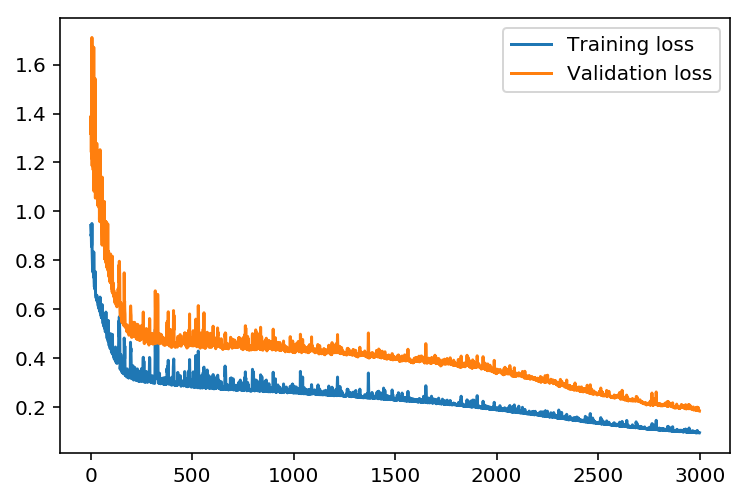

In [22]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## 检查预测结果

使用测试数据看看网络对数据建模的效果如何。如果完全错了，请确保网络中的每步都正确实现。

[[-5.30518303e-02]
 [-4.56083017e-01]
 [-1.09779664e+00]
 [-8.88331460e-01]
 [-9.60382461e-01]
 [-1.32817399e+00]
 [-9.65215139e-01]
 [-1.11926099e+00]
 [-2.83532609e-01]
 [ 8.73593813e-01]
 [ 1.93460353e+00]
 [ 5.89131290e-01]
 [-3.96007791e-02]
 [-2.04583886e-02]
 [ 1.92725238e-01]
 [ 3.60963027e-01]
 [ 2.66307009e-01]
 [ 3.61475461e-01]
 [ 8.64838823e-01]
 [ 1.95954574e+00]
 [ 1.85514868e+00]
 [ 1.08642456e+00]
 [ 5.44568945e-01]
 [ 2.56497679e-01]
 [-7.06935068e-02]
 [-3.85363456e-01]
 [-7.12672906e-01]
 [-8.70168366e-01]
 [-9.21851698e-01]
 [-9.02325875e-01]
 [-8.80336937e-01]
 [-6.99694104e-01]
 [-3.22636917e-01]
 [ 8.75817039e-01]
 [ 1.78612491e+00]
 [ 5.69040482e-01]
 [-1.27387884e-01]
 [-5.73332709e-02]
 [ 2.87470621e-01]
 [ 3.36718984e-01]
 [ 2.33150831e-01]
 [ 3.08317435e-01]
 [ 7.82715753e-01]
 [ 1.93336696e+00]
 [ 1.82119891e+00]
 [ 9.82677871e-01]
 [ 4.34418029e-01]
 [ 1.24527484e-01]
 [-1.59221446e-01]
 [-4.52377221e-01]
 [-7.67941274e-01]
 [-9.06339241e-01]
 [-9.3016396

d:\program\anoconda3-5.1.0\envs\ai\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


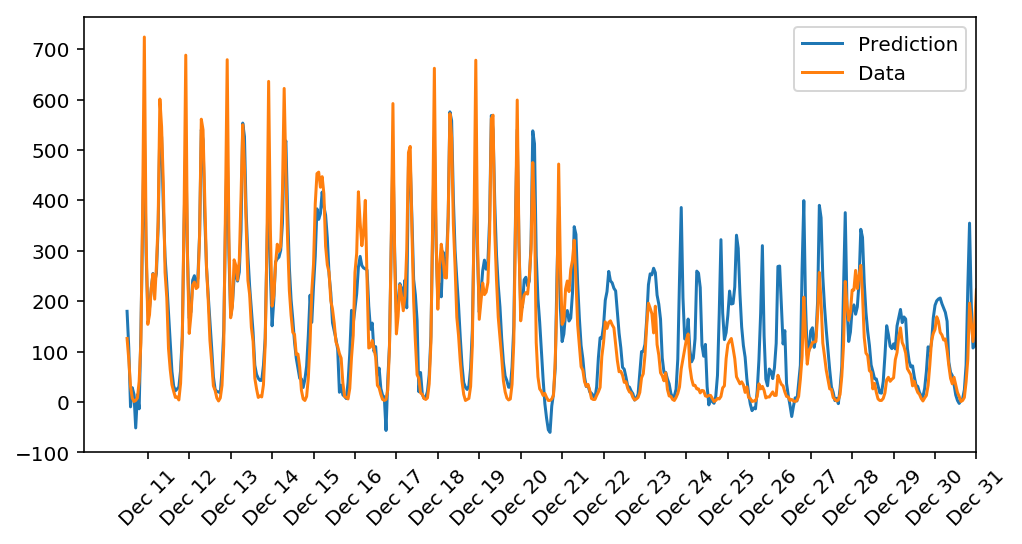

In [23]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## 可选：思考下你的结果（我们不会评估这道题的答案）

 
请针对你的结果回答以下问题。模型对数据的预测效果如何？哪里出现问题了？为何出现问题呢？

> **注意**：你可以通过双击该单元编辑文本。如果想要预览文本，请按 Control + Enter

#### 请将你的答案填写在下方


结果：调整参数后，这次预测结果挺好的。从图形来看，Dec 25左右可能受到圣诞节的影响，导致预测偏差较大